## 1. Building ENM 

In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from prody import *
from pylab import *
import Bio.PDB
from scipy.stats import pearsonr
from scipy.spatial import distance
from MDAnalysis.analysis import distances
from scipy.linalg import fractional_matrix_power
from scipy.optimize import minimize
from numpy import diff
import pandas as pd

In [2]:
pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/2FJG_fv.pdb"
u = mda.Universe(pdb, pdb)
CA = u.select_atoms('name CA')
n_res = CA.n_residues
spring_constant = 1
temperature = 310
RT = temperature*8.314/1000

In [3]:
def get_positions(CA):
    positions = CA.positions/10 # In nano meters
    distance_map = distance.cdist(positions, positions)
    distance_map = np.repeat(np.repeat(distance_map, 3, axis=1), 3, axis=0)
    inv_distsq_map = distance_map**-2
    inv_distsq_map[inv_distsq_map == np.inf] = 0
    return positions, distance_map, inv_distsq_map

def get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant):
    kirchoff_matrix = np.ones((n_res*3, n_res*3))
    kirchoff_matrix[distance_map>cutoff] = 0
    kirchoff_matrix = spring_constant*kirchoff_matrix
    return kirchoff_matrix

def get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res):
    xx_distance_map = distance.cdist(positions[:, 0].reshape(-1, 1), positions[:, 0].reshape(-1, 1), lambda u, v: u-v)
    yy_distance_map = distance.cdist(positions[:, 1].reshape(-1, 1), positions[:, 1].reshape(-1, 1), lambda u, v: u-v)
    zz_distance_map = distance.cdist(positions[:, 2].reshape(-1, 1), positions[:, 2].reshape(-1, 1), lambda u, v: u-v)

    H = np.zeros((n_res*3, n_res*3))
    H[0::3, 0::3] = xx_distance_map * xx_distance_map
    H[1::3, 1::3] = yy_distance_map * yy_distance_map
    H[2::3, 2::3] = zz_distance_map * zz_distance_map
    H[0::3, 1::3] = xx_distance_map * yy_distance_map
    H[0::3, 2::3] = xx_distance_map * zz_distance_map
    H[1::3, 2::3] = yy_distance_map * zz_distance_map
    H[1::3, 0::3] = xx_distance_map * yy_distance_map
    H[2::3, 0::3] = xx_distance_map * zz_distance_map
    H[2::3, 1::3] = yy_distance_map * zz_distance_map
    H = -1 * kirchoff_matrix * inv_distsq_map * H

    for i in range(n_res):
        H[i*3+0, i*3+0] = -1*np.sum(H[i*3+0, 0::3])
        H[i*3+1, i*3+1] = -1*np.sum(H[i*3+1, 1::3])
        H[i*3+2, i*3+2] = -1*np.sum(H[i*3+2, 2::3])
        H[i*3+0, i*3+1] = -1*np.sum(H[i*3+0, 1::3])
        H[i*3+1, i*3+0] = H[i*3+0, i*3+1]
        H[i*3+0, i*3+2] = -1*np.sum(H[i*3+0, 2::3])
        H[i*3+2, i*3+0] = H[i*3+0, i*3+2]
        H[i*3+1, i*3+2] = -1*np.sum(H[i*3+1, 2::3])
        H[i*3+2, i*3+1] = H[i*3+1, i*3+2]  
    return H

def get_mass_matrix(CA):
    residue_mass = CA.residues.masses/1000
    residue_mass = np.repeat(residue_mass, 3)
    M = np.diag(residue_mass)
    M_f = fractional_matrix_power(M, -0.5)
    return M_f

def get_mass_weighted_H(M_f, H):
    H_m = (M_f@H)@M_f
    return H_m

def get_fluctuations(M_f, H_m, RT):
    [v, U_m] = np.linalg.eig(H_m)
    U_m = U_m[:, np.argsort(v)]
    v = v[np.argsort(v)]
    U_m = U_m.astype('float64')
    M_f = M_f.astype('float64')
    v = v.astype('float64')
    m = len(H_m[0])
    C = np.zeros((np.shape(H_m)))
    for i in range(len(v)-6):
        C += (np.outer((M_f@U_m[:, i+6]), U_m[:, i+6].T)@M_f)/v[i+6]
    C = RT*C
    sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
    F = np.sqrt(sq_fluctuations)
    return sq_fluctuations, F

In [4]:
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
def fluctuations(CA, n_res, cutoff, spring_constant):
    kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
    H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
    H_m = get_mass_weighted_H(M_f, H)
    sq_fluctuations, F = get_fluctuations(M_f, H_m, RT)
    return sq_fluctuations, F

/var/tmp/pbs.3547524.pbshpc/ipykernel_19424/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


In [5]:
rmsf_L = np.genfromtxt('/scratch/chemical/dual/ch7180271/MTP_Work/LangevinDynamics/rmsf_chL1000.xvg')[:, 1]
rmsf_H = np.genfromtxt('/scratch/chemical/dual/ch7180271/MTP_Work/LangevinDynamics/rmsf_chH1000.xvg')[:, 1]
rmsf = np.hstack((rmsf_L, rmsf_H))*10

In [6]:
cutoff = range(10, 20)
pearson_corr = []
for Rc in cutoff:
    sq_fluctuations_P, F_P = fluctuations(CA, n_res, Rc/10, spring_constant)
    corr, _ = pearsonr(rmsf, F_P)
    pearson_corr.append(corr)

/var/tmp/pbs.3547524.pbshpc/ipykernel_19424/2539767524.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  U_m = U_m.astype('float64')
/var/tmp/pbs.3547524.pbshpc/ipykernel_19424/2539767524.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  v = v.astype('float64')


In [7]:
pearson_corr

[0.6015655175071924,
 0.6052678728177874,
 0.5939029947897023,
 0.5808826570611072,
 0.5551867132454995,
 0.5306128202105821,
 0.5117042228088018,
 0.47595119954821735,
 0.4571299545578476,
 0.43639951507752556]

Maximum pearson coefficient is 0.6052678728177874 at:  1.1 nanoseconds


Text(0, 0.5, 'Pearson Coefficient')

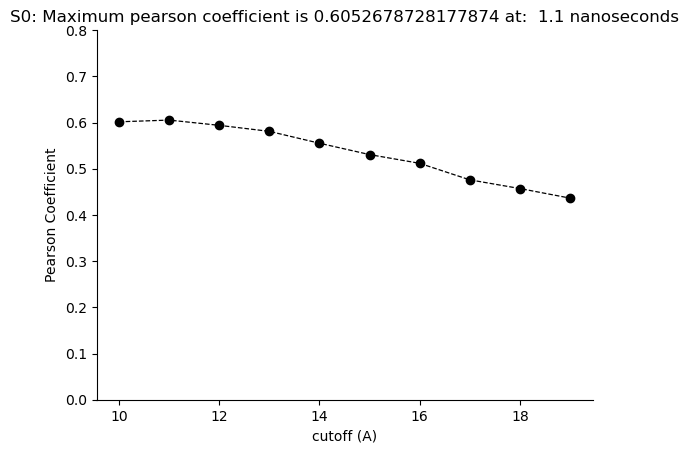

In [8]:
# With my 1ns rmsf
index = pearson_corr.index(max(pearson_corr))
opt_Rc = cutoff[index]/10
print('Maximum pearson coefficient is', max(pearson_corr), 'at: ', opt_Rc, 'nanoseconds')
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0, 0.8)
plt.title("S0: Maximum pearson coefficient is 0.6052678728177874 at:  1.1 nanoseconds")
plt.xlabel("cutoff (A)", fontsize = 10)
plt.ylabel("Pearson Coefficient", fontsize = 10)

Text(0, 0.5, 'Sq fluctuations (A2)')

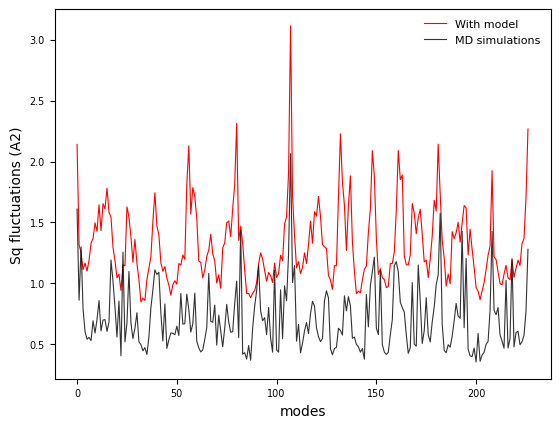

In [9]:
sq_fluctuations, F = fluctuations(CA, n_res, opt_Rc, spring_constant)
plt.plot(F, label = "With model", color = 'red', linewidth=0.8)
plt.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

In [10]:
scale = (sq_fluctuations.mean()/rmsf.mean()**2)
print('The scale (kJ/A^2)is:', scale)

The scale (kJ/A^2)is: 3.616691332190901


In [11]:
spring_constant = spring_constant*scale
sq_fluctuations_scale, F_scale = fluctuations(CA, n_res, opt_Rc, spring_constant)

Text(0, 0.5, 'Sq fluctuations (A2)')

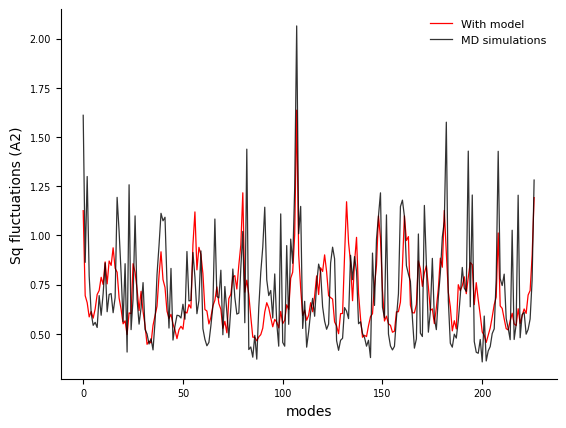

In [12]:
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
ax.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

Text(-1, 2, 'C')

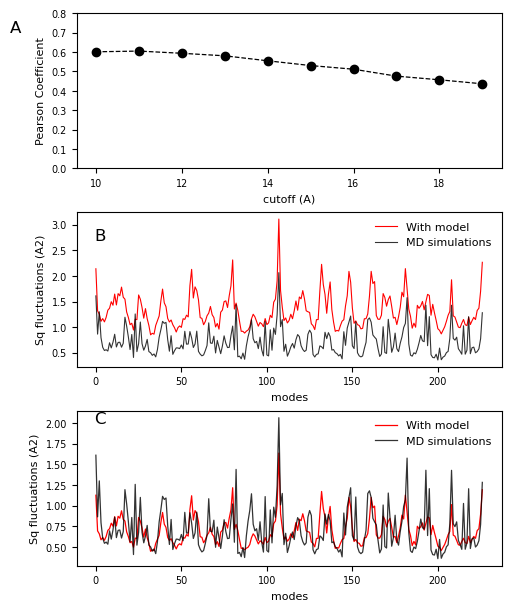

In [13]:
fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 6), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[1].plot(F, label = "With model", color = 'red', linewidth=0.8)
axes[1].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
axes[1].legend(frameon = False, prop={'size':8})
axes[1].set_xlabel("modes", fontsize = 8)
axes[1].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[1].text(-50, 2.7, "B", fontsize = 12)
axes[0].plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
axes[0].set_ylim(0, 0.8)
axes[0].text(8, 0.7, "A", fontsize = 12)
axes[0].set_xlabel("cutoff (A)", fontsize = 8)
axes[0].set_ylabel("Pearson Coefficient", fontsize = 8)
axes[2].plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
axes[2].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
axes[2].legend(frameon = False, prop={'size':8})
axes[2].set_xlabel("modes", fontsize = 8)
axes[2].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[2].text(-50, 2, "C", fontsize = 12)

## 2. Direction of change 

In [12]:
cutoff = opt_Rc
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
H_m = get_mass_weighted_H(M_f, H)
[v, U_m] = np.linalg.eig(H_m)
arr_v = v
U_m = U_m[:, np.argsort(v)]
v = v[np.argsort(v)]  #eigenvalue
U = M_f @ U_m  #eigenvector

/var/tmp/pbs.3539253.pbshpc/ipykernel_9279/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


#### Excitation along normal modes

In [ ]:
box = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/box.pdb"
pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(Um[0].shape)
    v_extra = *Um[cycle]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [ ]:
def save_gro(Um, v_extra, gro_in, delT, cycle):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = '/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/{}_delT/{}_mode/md.gro'.format(delT, cycle)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [ ]:
gro_in = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/md.gro"
delT = [75, 100]
for i in delT:
    for j in range(20):
        v_extra = excite(Um, box, i, cycle)
        save_gro(Um, v_extra, gro_in, i, cycle)

#### RMSD Projections and plots

In [13]:
from MDAnalysis.analysis import align
import sys

box = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/box.pdb"
pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(U_m.shape[0])
    v_extra = Um[cycle]
    v_extra = v_extra/np.linalg.norm(v_extra)
    u = mda.Universe(box, box)
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite, (antibody.atoms.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, cycle, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT, cycle)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

In [14]:
# For delT = 75
delT = 75
rd_75 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/xtc_mdenm_6.xtc".format(i)    
    pdb_ref = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_75.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 75 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
#     plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

In [15]:
# For delT = 100
delT = 100
rd_100 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/xtc_mdenm_6.xtc".format(i)
    pdb_ref = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_100.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 100 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
# #    plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

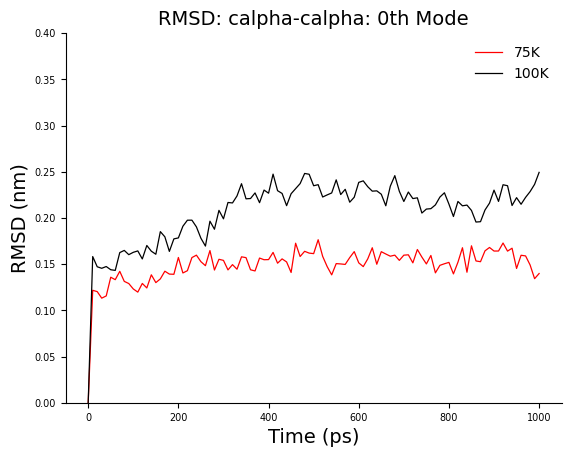

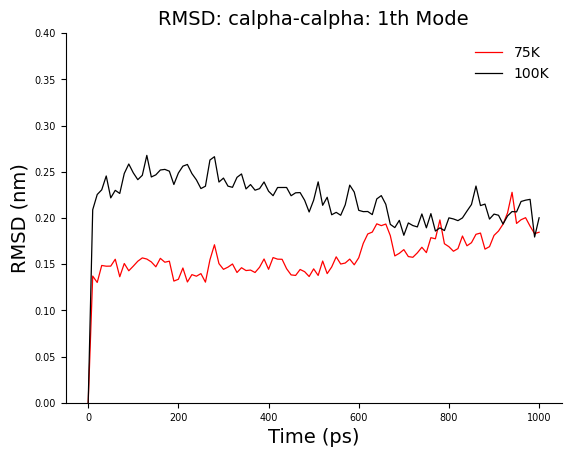

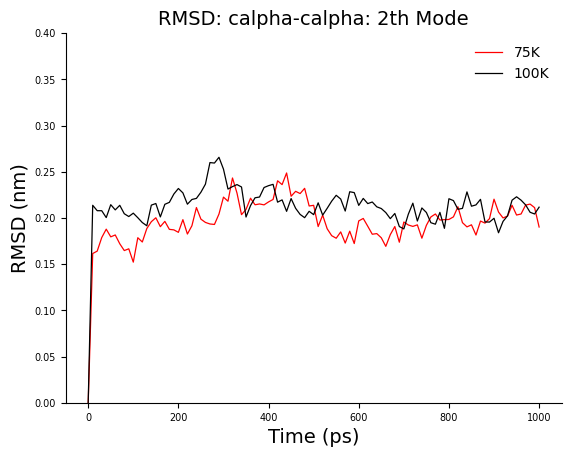

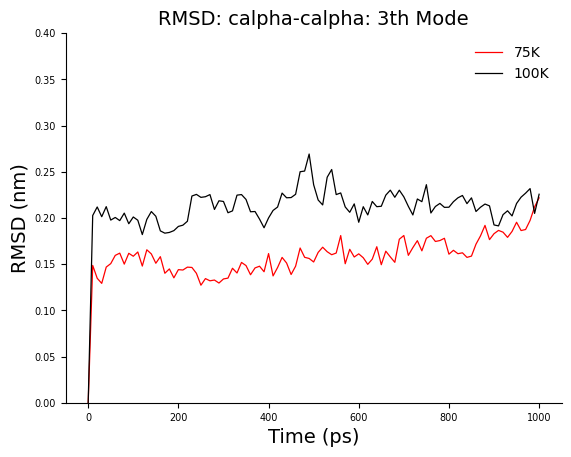

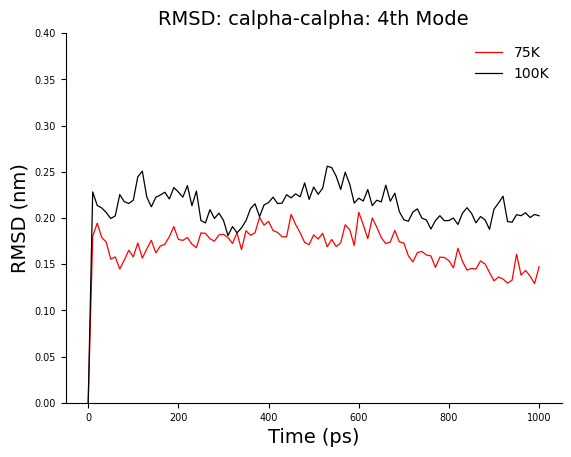

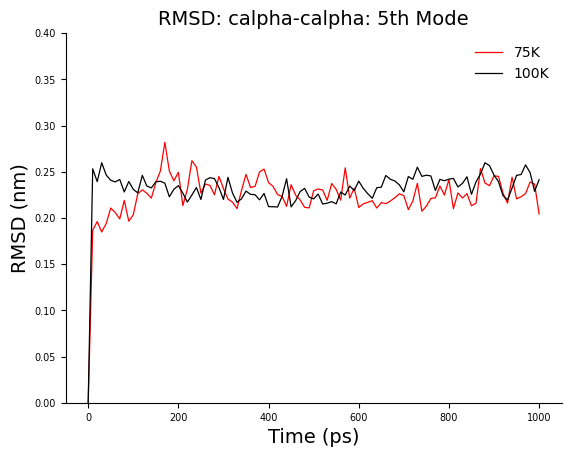

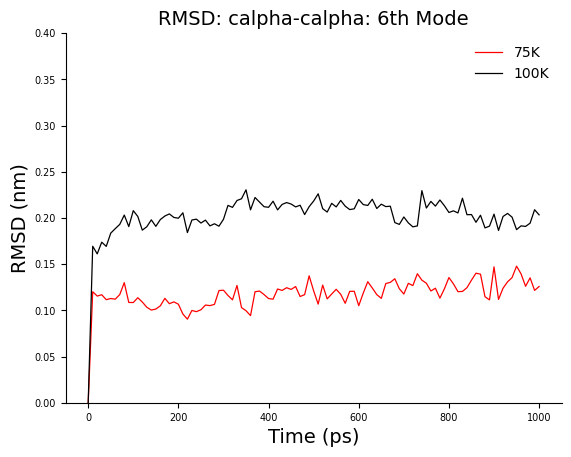

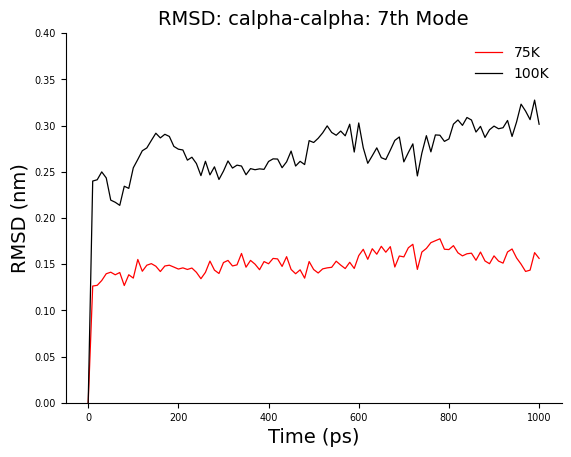

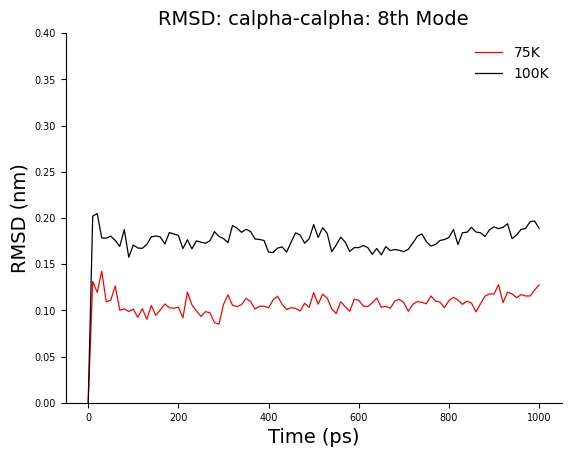

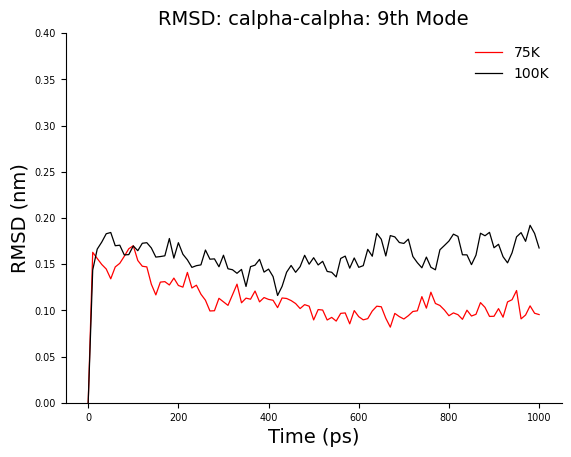

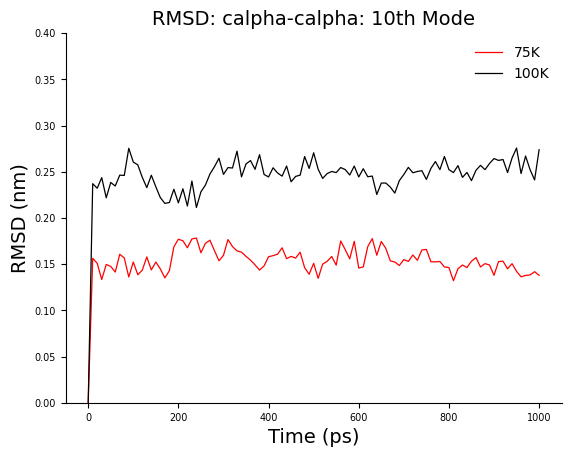

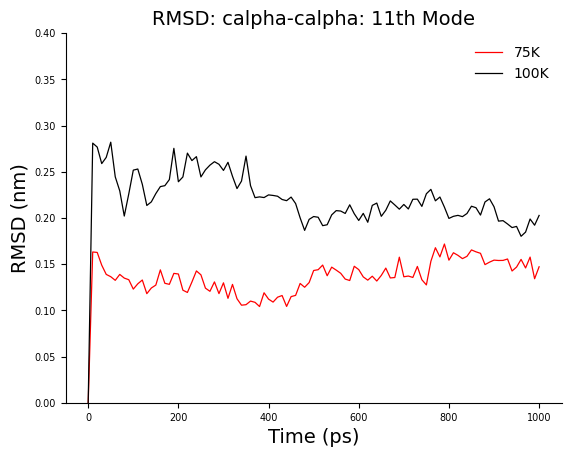

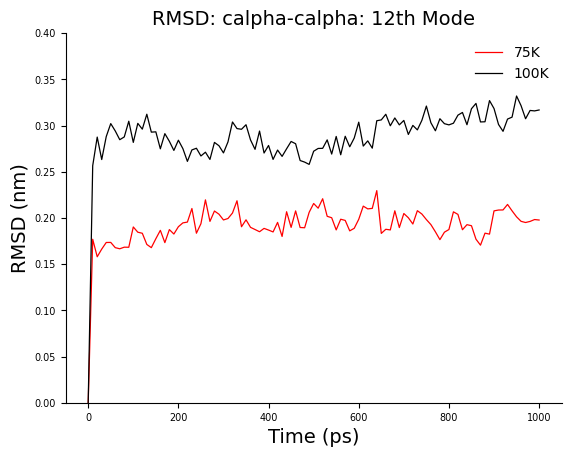

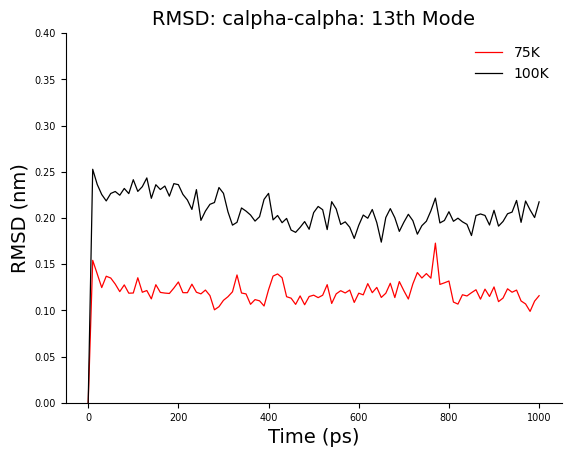

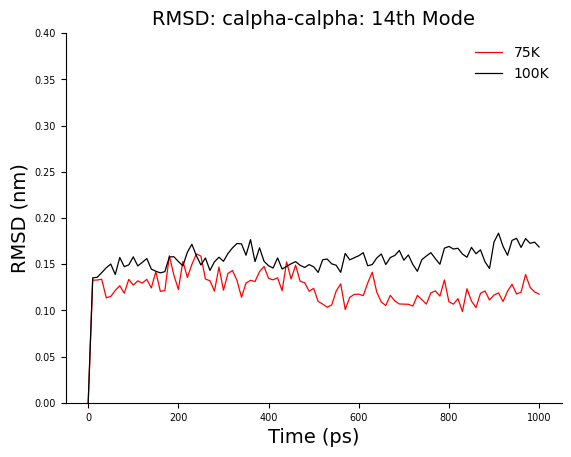

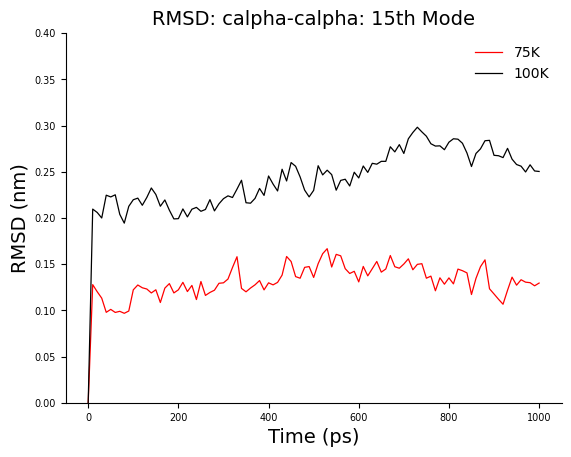

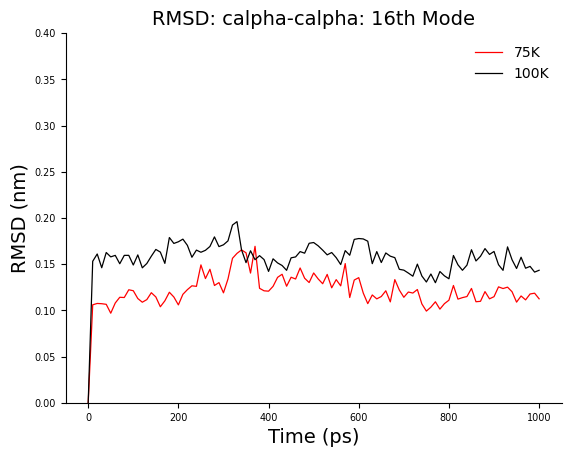

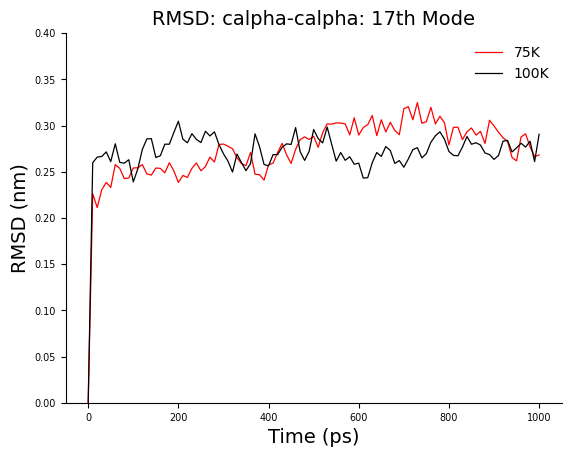

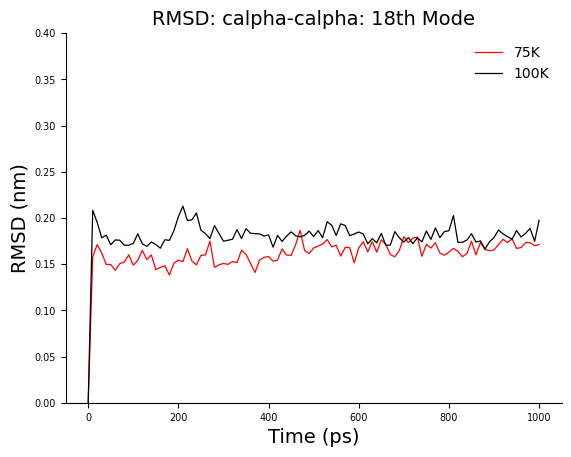

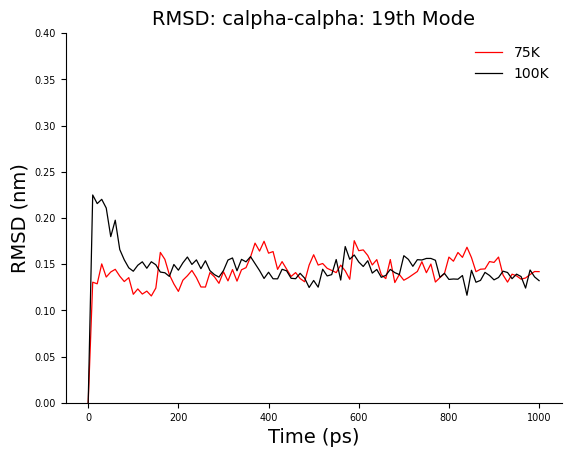

In [16]:
rmsdcc_75 = []
rmsdcc_100 = []

for i in range(20):
    filename = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsd_calpha_calpha_6.xvg".format(i)
    rmsd_75 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_75.append(rmsd_75[:, 1])
    filename = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsd_calpha_calpha_6.xvg".format(i)
    rmsd_100 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_100.append(rmsd_100[:, 1])
    plt.figure()
    ax = plt.subplot()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(rmsd_75[:, 0], rmsd_75[:, 1], label = '75K', color = 'red', linewidth = 0.9)
    ax.plot(rmsd_100[:, 0], rmsd_100[:, 1], label = '100K', color = 'black', linewidth = 0.9)
    plt.xlabel("Time (ps)", fontsize = 14)
    plt.ylabel("RMSD (nm)", fontsize = 14)
    plt.ylim(0, 0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("RMSD: calpha-calpha: {}th Mode".format(i), fontsize = 14)
    plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSD (nm)')

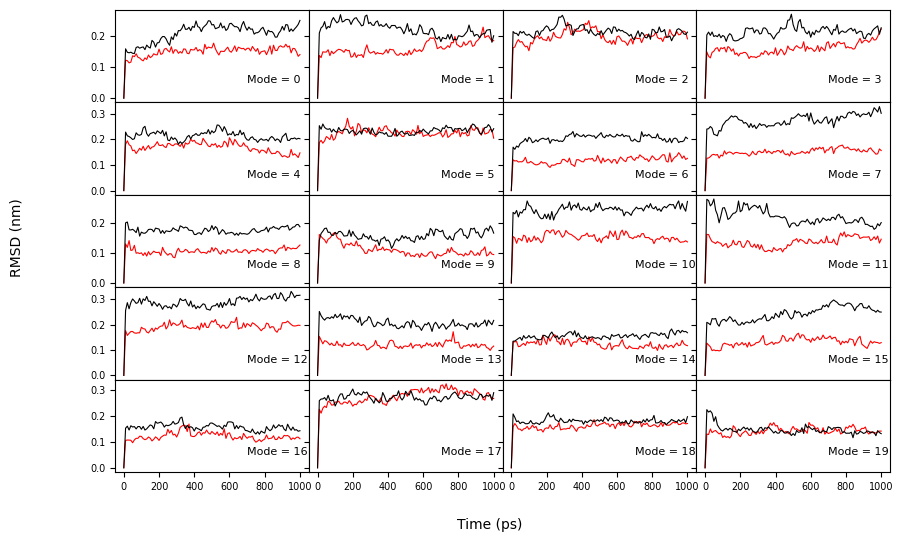

In [17]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(700, 0.05, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD (nm)')

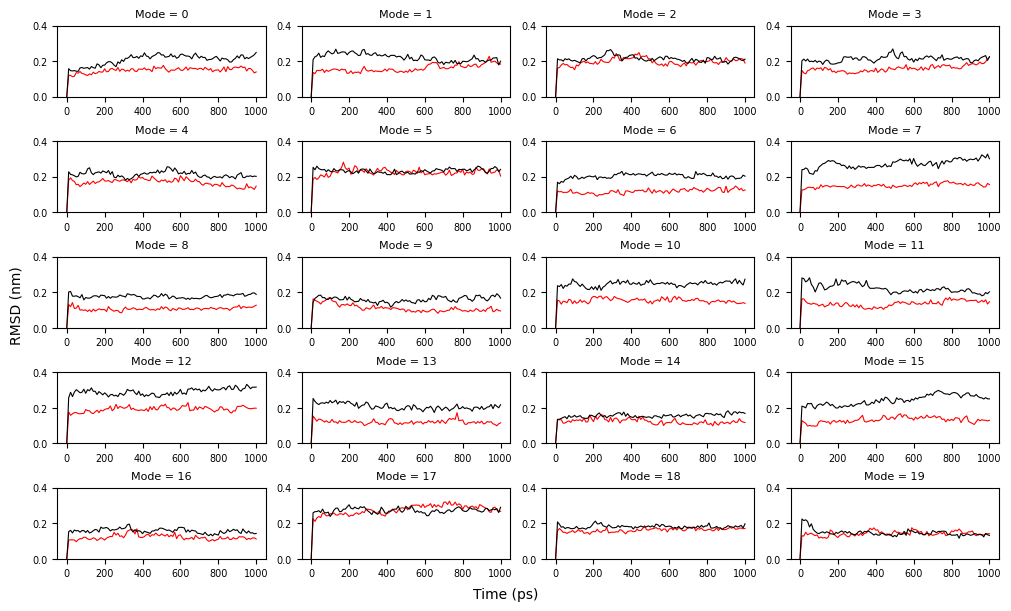

In [18]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper left", prop={'size':5})
        axes[i, j].set_ylim(0, 0.4)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD: calpha-calpha', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

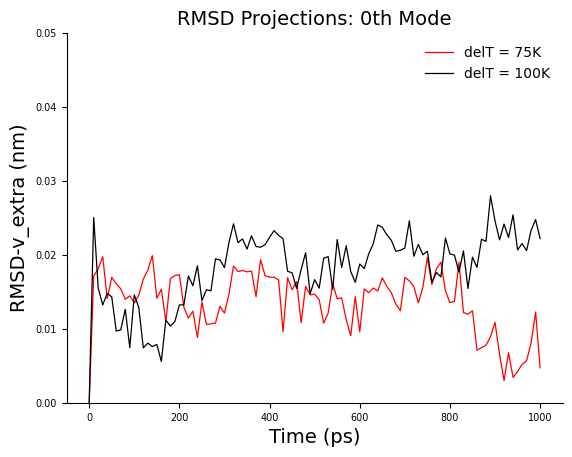

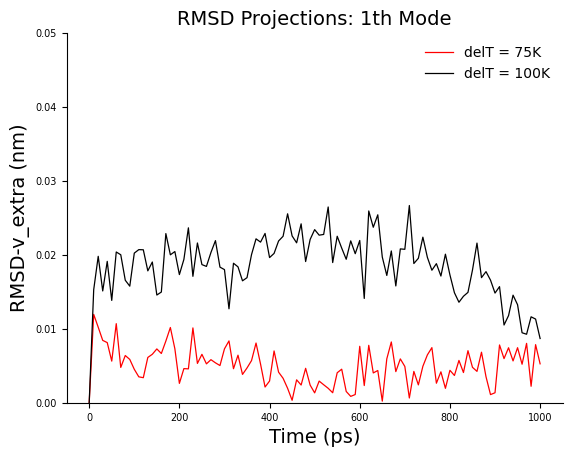

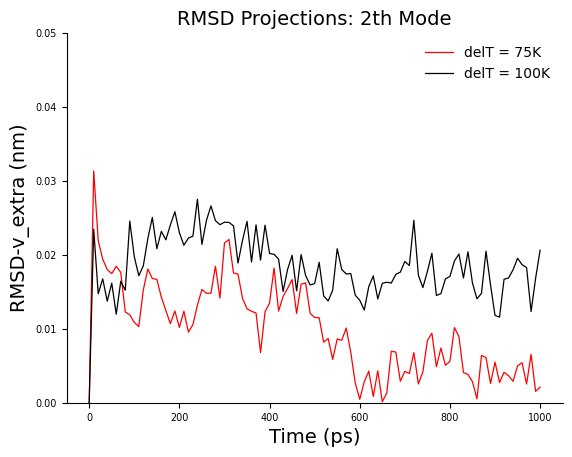

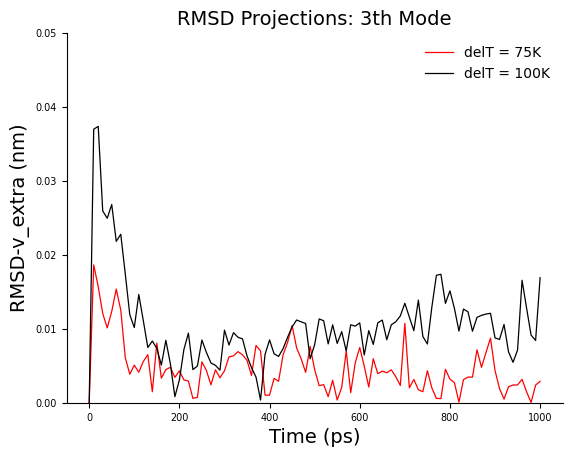

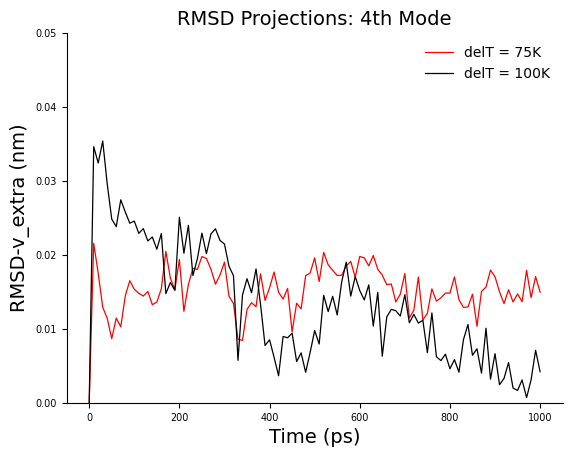

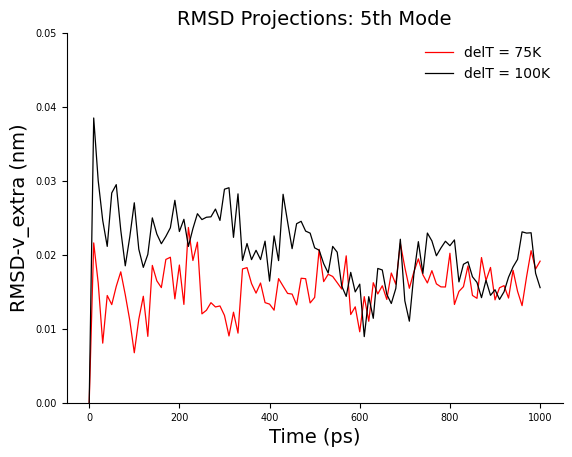

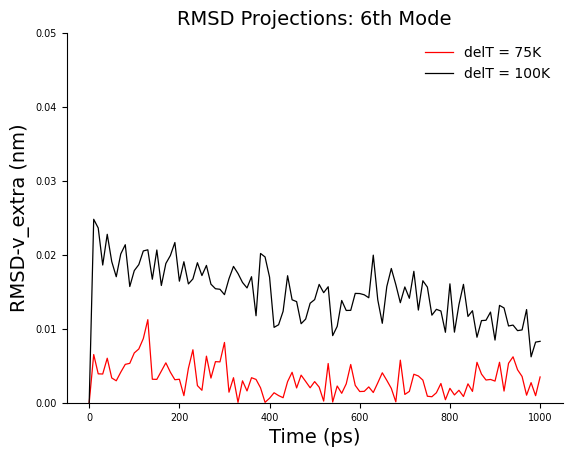

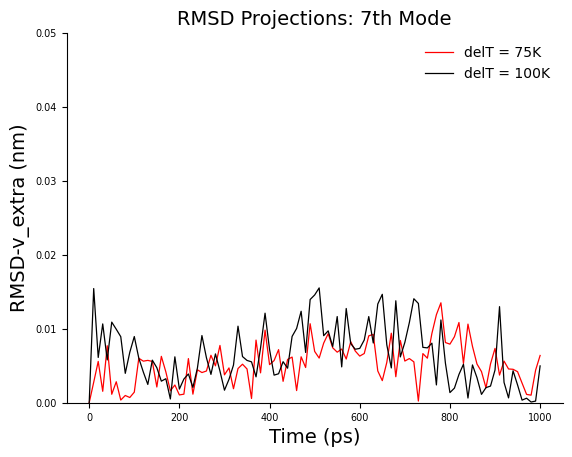

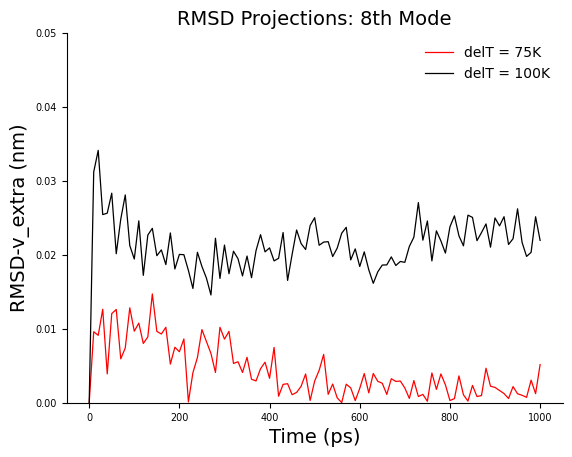

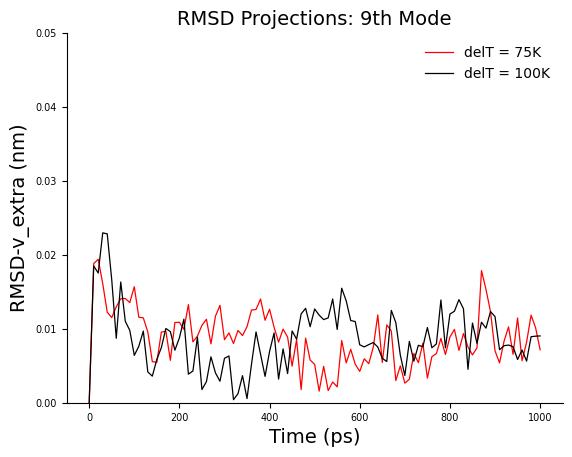

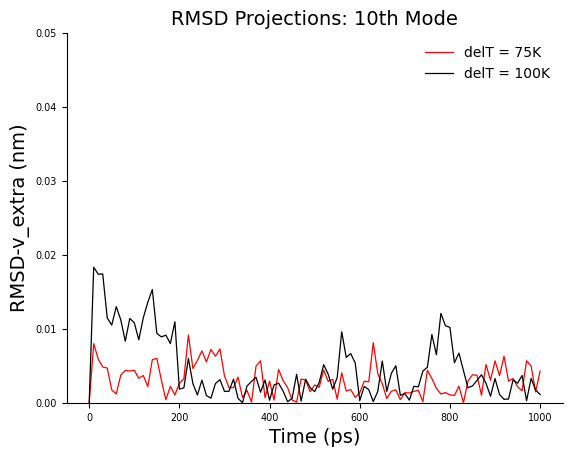

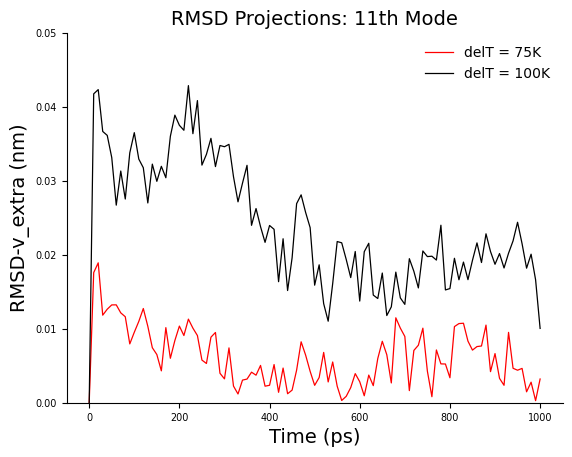

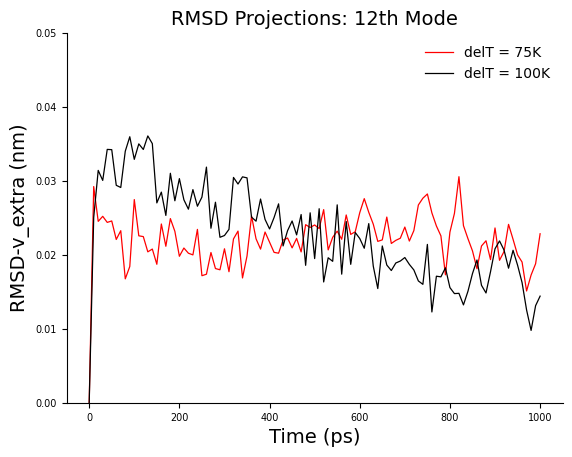

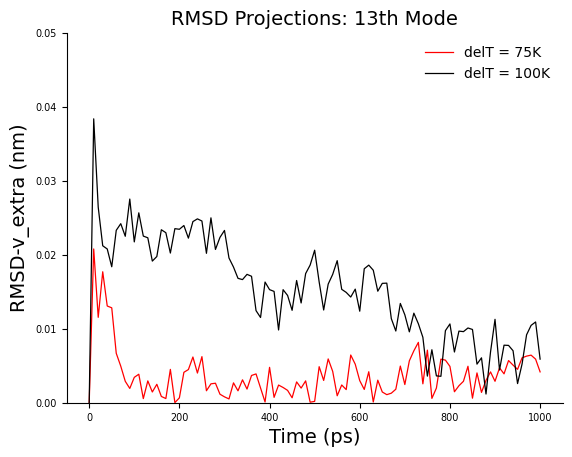

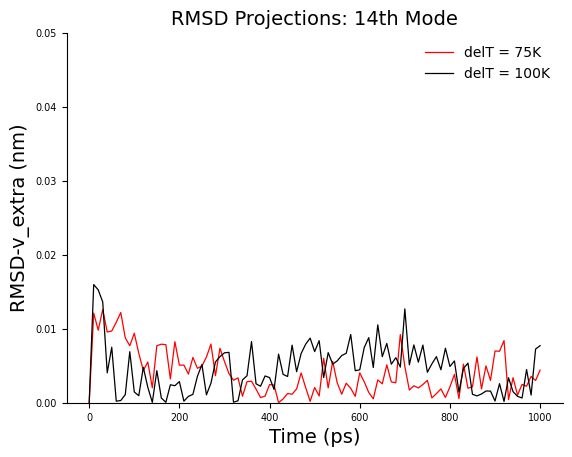

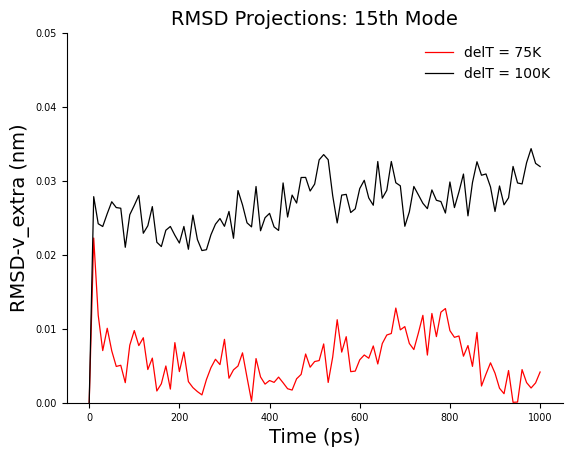

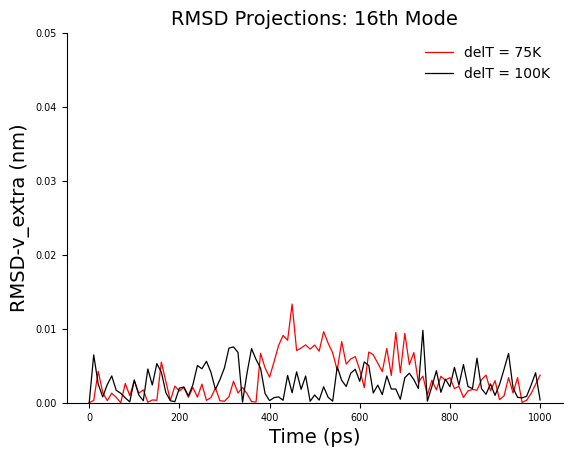

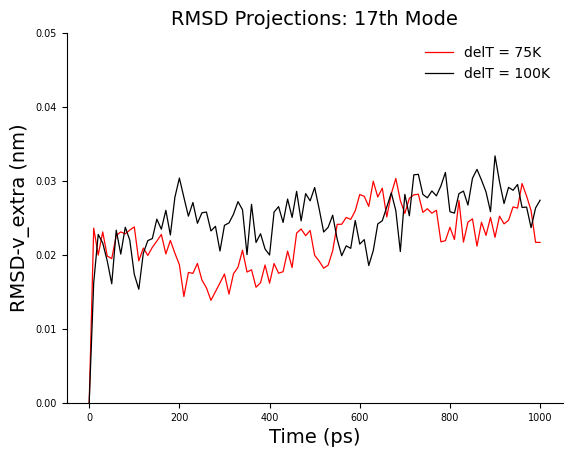

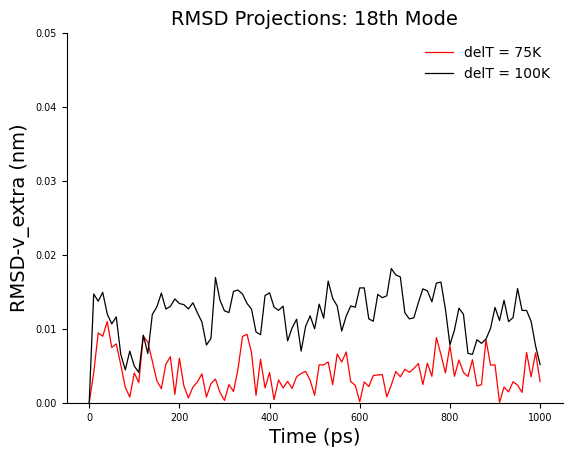

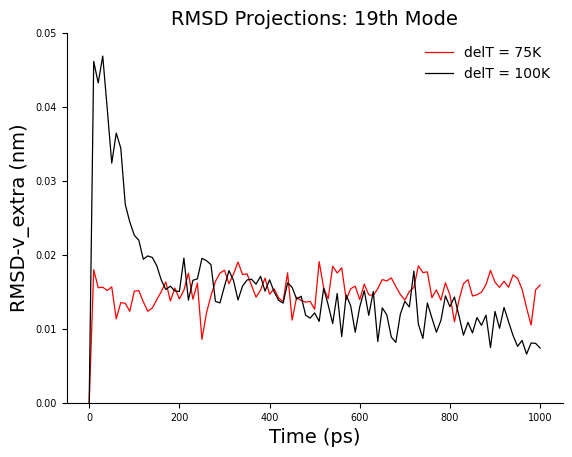

In [19]:
time = [i*10 for i in range(101)]

for i in range(20):
    fig, ax = plt.subplots()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(time, rd_75[i], label = 'delT = 75K', color = 'red', linewidth = 0.9)
    ax.plot(time, rd_100[i], label = 'delT = 100K', color = 'black', linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':10})
    ax.set_xlabel('Time (ps)', fontsize = 14)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 14)
    ax.set_ylim(0, 0.05)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('RMSD Projections: {}th Mode'.format(i), fontsize = 14)
    plt.show()

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

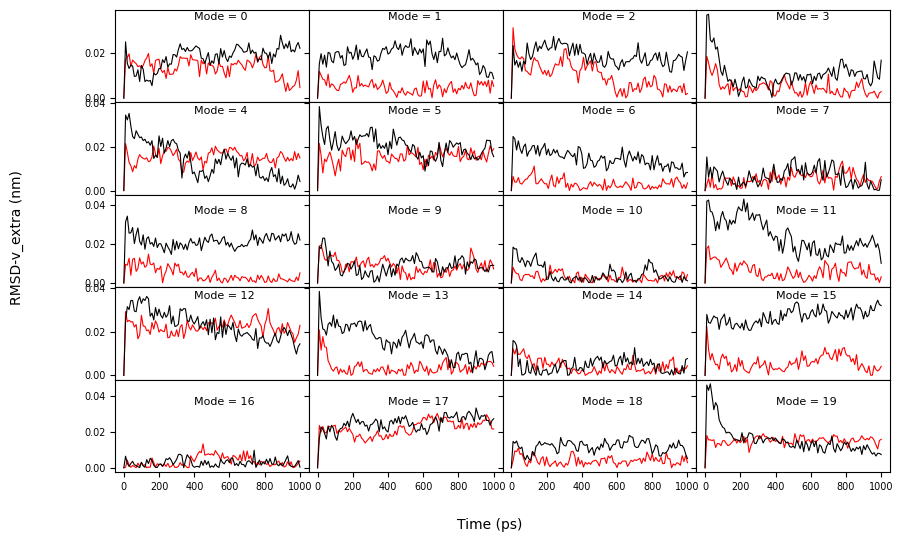

In [20]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(400, 0.035, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

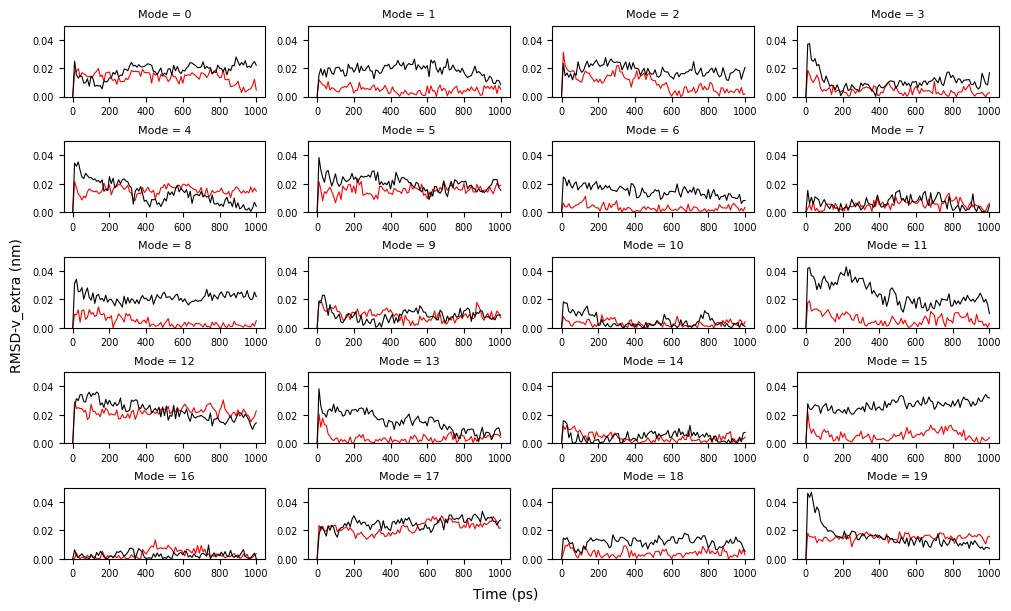

In [21]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
        axes[i, j].set_ylim(0, 0.05)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.5, 1.0, 'B')

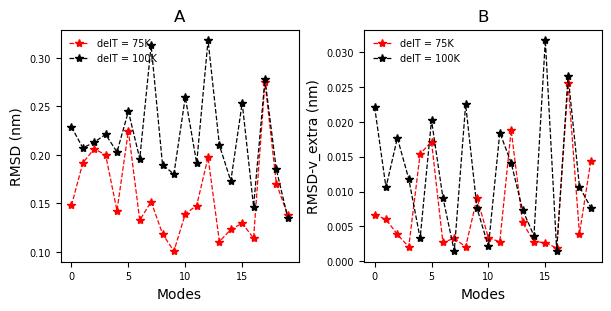

In [22]:
avg_rmsdcc_75 = []
avg_rmsdcc_100 = []
avg_rd_75 = []
avg_rd_100 = []
mode_lst = []
for k in range(20):
    avg_rmsdcc_75.append(np.average(rmsdcc_75[k][95:]))
    avg_rmsdcc_100.append(np.average(rmsdcc_100[k][95:]))
    avg_rd_75.append(np.average(rd_75[k][95:]))
    avg_rd_100.append(np.average(rd_100[k][95:]))
    mode_lst.append(k)
    

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[0].plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
axes[0].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[0].set_xlabel("Modes", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[1].plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
axes[1].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[1].set_xlabel("Modes", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)

    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper left", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSF (nm)')

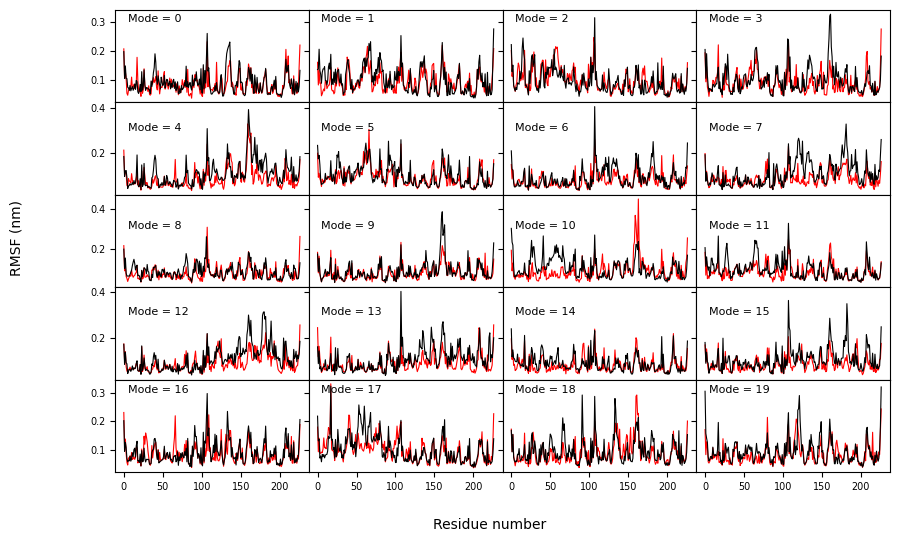

In [23]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_100 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_100, color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSF (nm)')

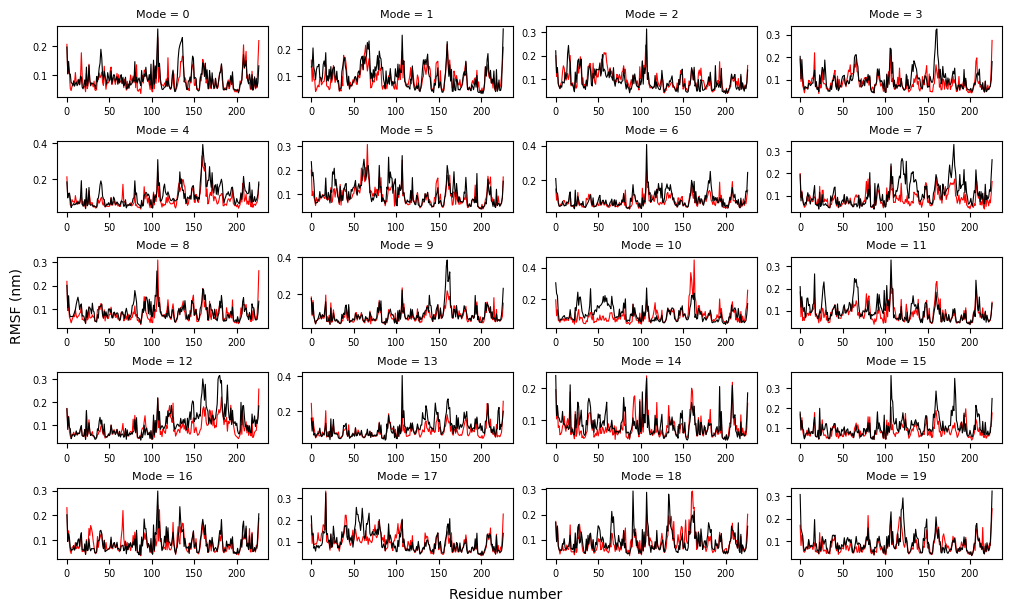

In [24]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_100 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_100, color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

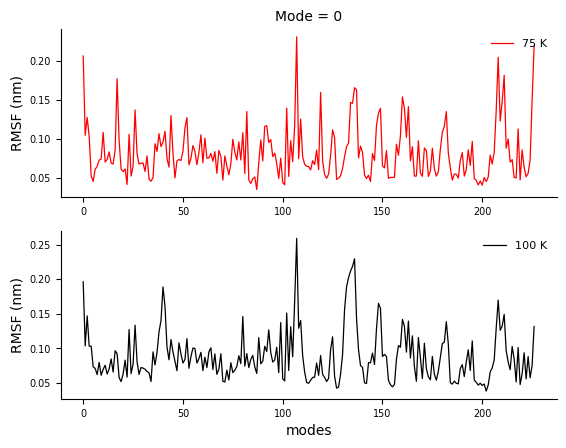

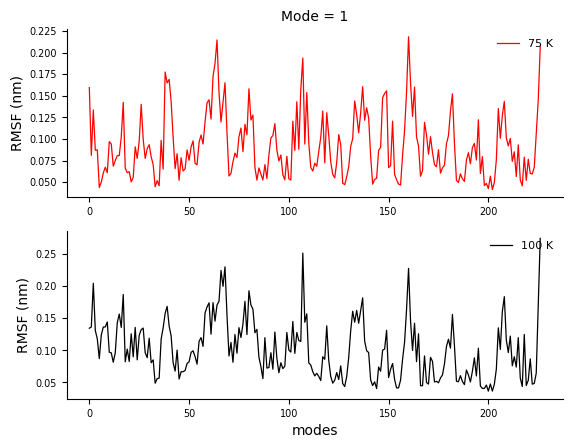

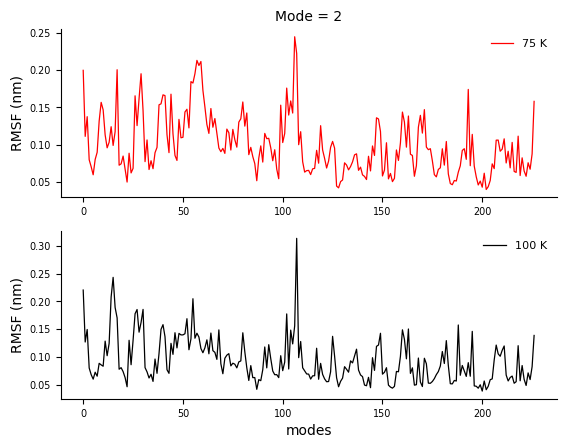

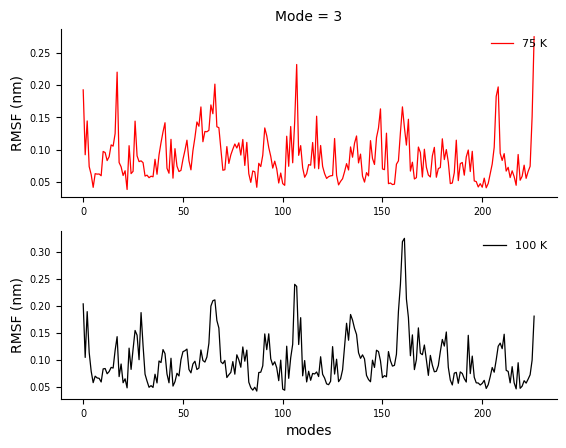

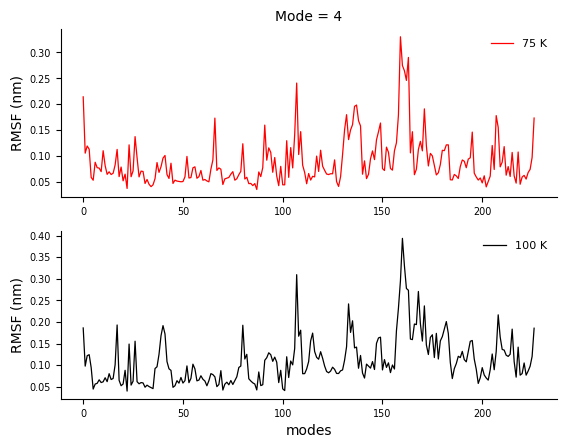

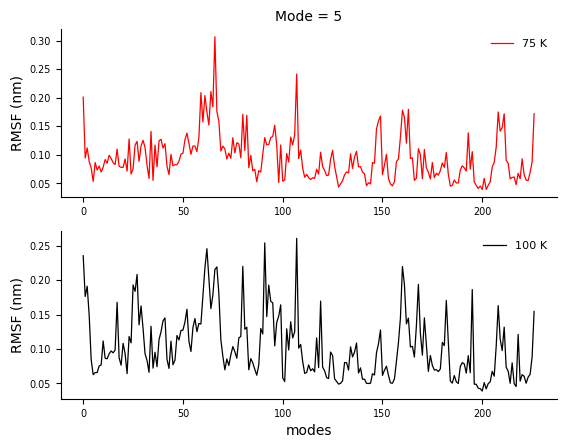

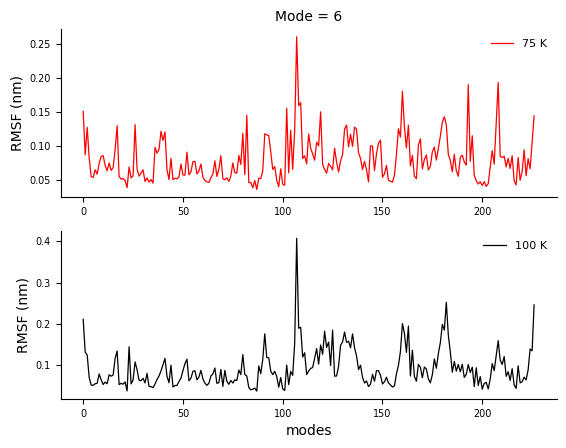

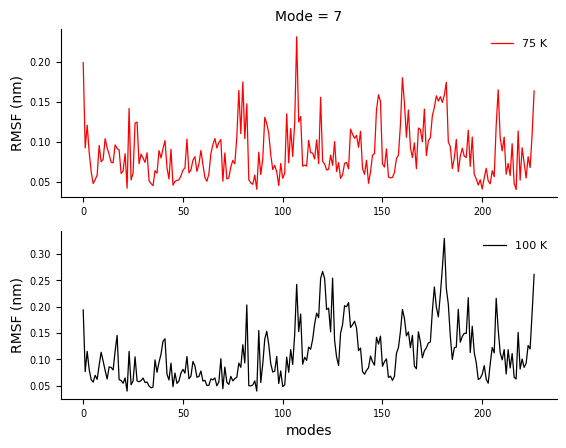

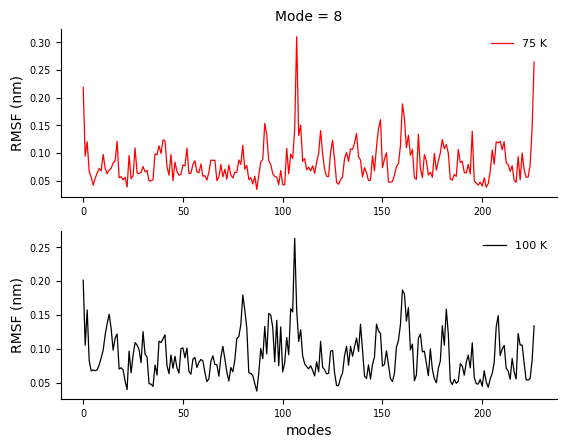

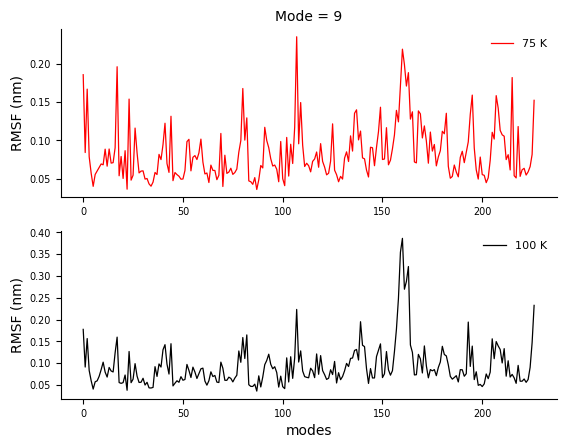

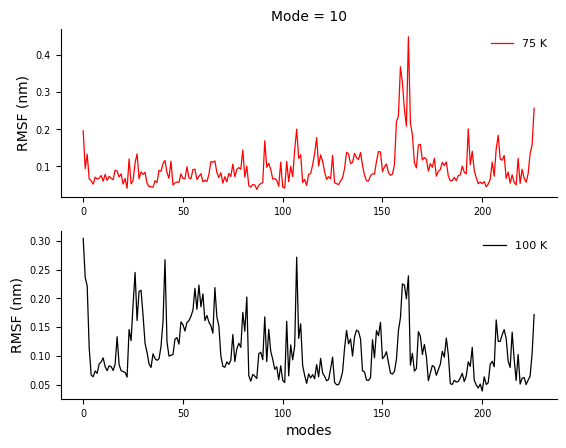

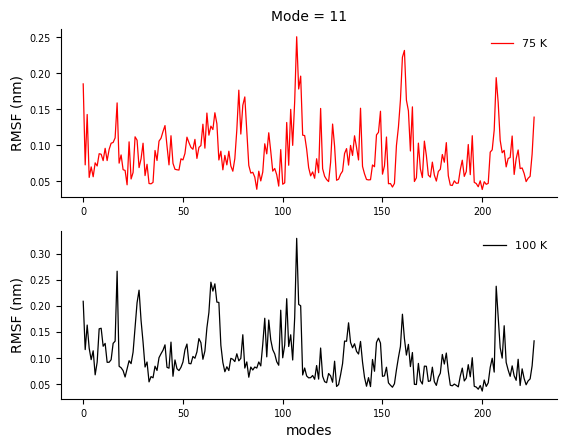

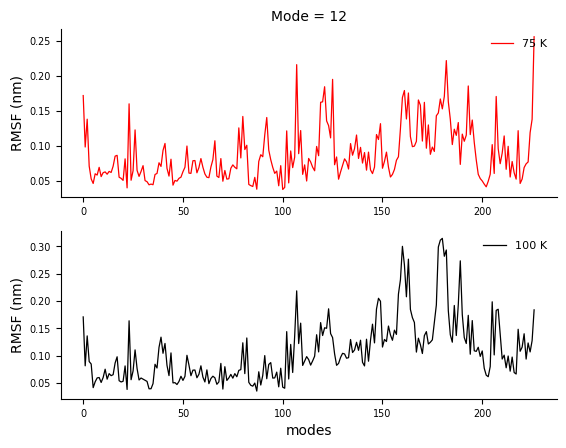

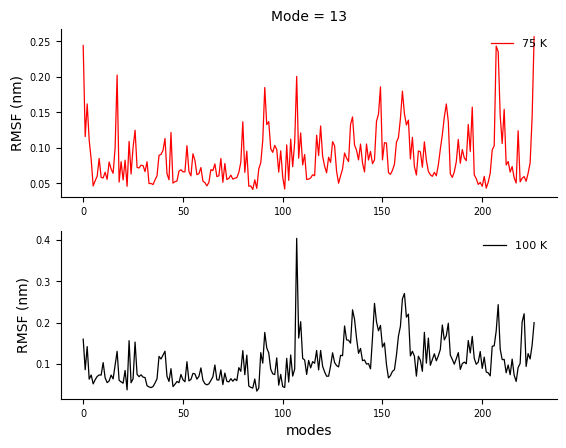

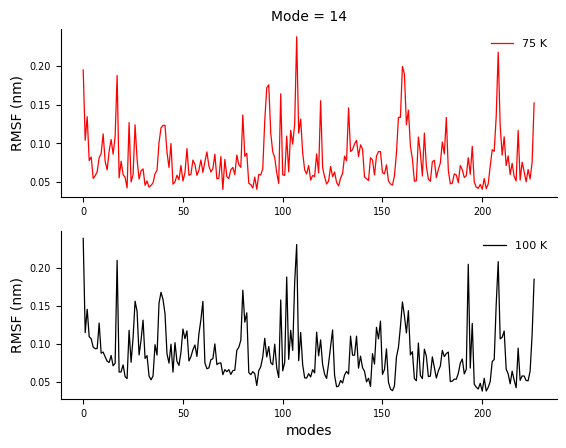

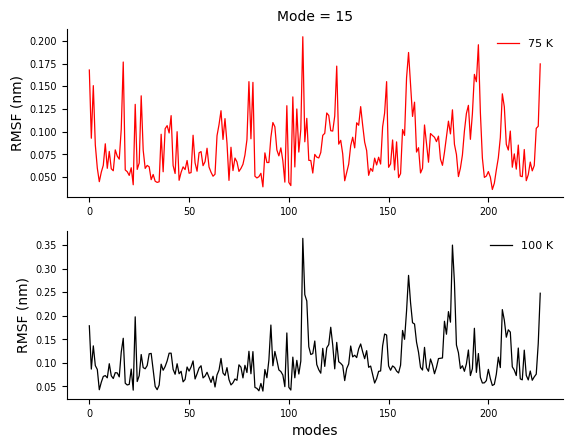

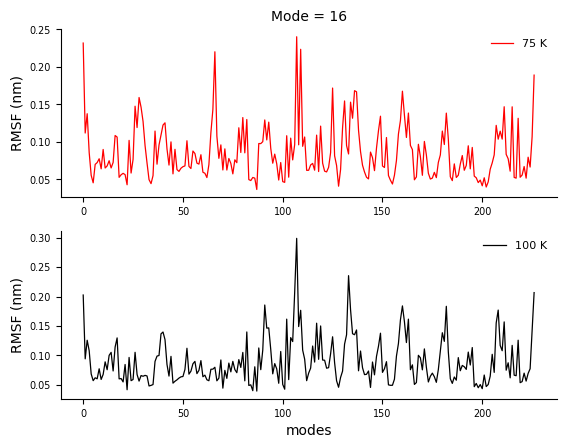

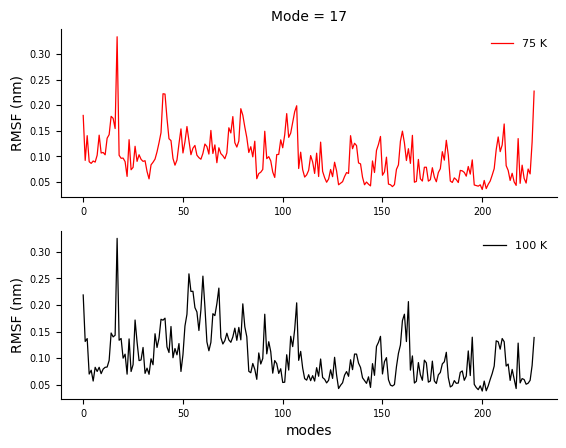

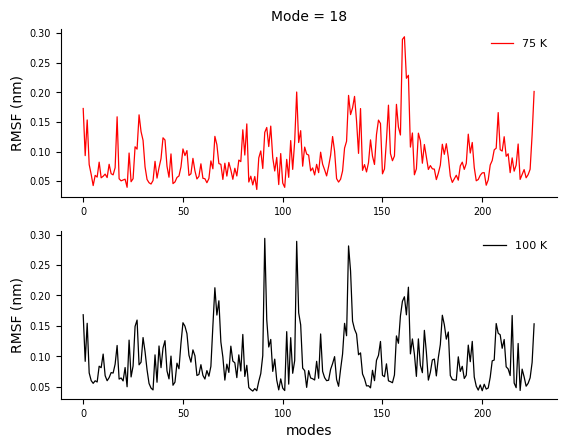

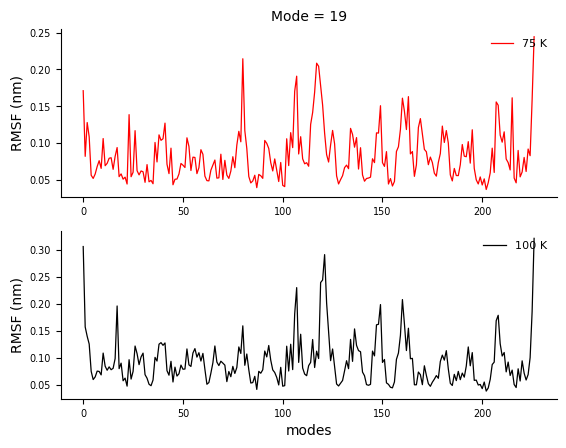

In [25]:
for i in range(20):
    rmsf_L = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsf_chL.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/75_delT_1/{}_mode/rmsf_chH.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_75 = np.hstack((rmsf_L, rmsf_H))
    rmsf_L = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsf_chL.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/100_delT_1/{}_mode/rmsf_chH.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_100 = np.hstack((rmsf_L, rmsf_H))
    fig, axes = plt.subplots(nrows=2,ncols=1)
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    axes[0].plot(rmsf_75, color = 'red', label = '75 K', linewidth = 0.9)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].set_ylabel("RMSF (nm)", fontsize = 10)
    axes[0].set_title("Mode = {}".format(i), fontsize = 10)
    axes[0].legend(frameon = False,loc ="upper right", prop={'size':8})
    axes[1].plot(rmsf_100, color = 'black', label = '100 K', linewidth = 0.9)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1].set_xlabel("modes", fontsize = 10)
    axes[1].set_ylabel("RMSF (nm)", fontsize = 10)

#### delT = 75; Finding the alpha

In [26]:
wm = v[6:26]
Um = U_m[6:26]
m = len(Um)
alpha = np.random.rand(m, 1)

In [27]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

1.154770723488241e-13
[0.16112004 0.08807341 0.05101883 0.01846937 0.11774762 0.10816501
 0.01507182 0.01833009 0.01053205 0.04208441 0.01372277 0.01100887
 0.06691579 0.01930561 0.00907921 0.00859142 0.00574084 0.07379803
 0.01068179 0.03789768]
-1.9999175926432855e-12
[0.48304074 0.26447512 0.15310248 0.05543315 0.35332038 0.32453418
 0.04514443 0.05495225 0.03160596 0.12626021 0.04122429 0.03296941
 0.20074776 0.05790241 0.02721126 0.02578487 0.01723204 0.22133432
 0.03209044 0.11370444]
1.8784279687267258e-13
[0.80507913 0.44061138 0.25509336 0.09233847 0.58891382 0.54093565
 0.07525824 0.09151664 0.05262076 0.21045494 0.06870785 0.05486825
 0.33462099 0.09643509 0.04534415 0.04294342 0.02871843 0.36884513
 0.05355388 0.1895657 ]


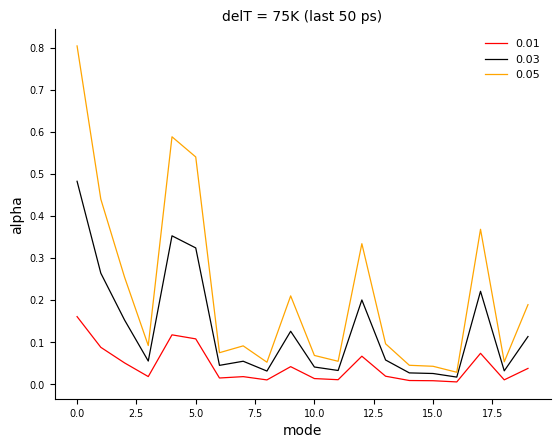

In [28]:
lst = [0.01, 0.03, 0.05]
alpha_75_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
#    alpha_m_75 = alpha_m_75/np.linalg.norm(alpha_m_75)
    alpha_75_5.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
#     plt.plot(alpha_m_75, label = str(i))
#     plt.title("delT = 75 (last 50 ps)")
#     plt.xlabel("mode")
#     plt.ylabel("alpha")
#     plt.legend(loc ="upper right", ncol = 1, prop={'size':10})
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 50 ps)", fontsize = 10)
plt.show()

In [29]:

def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

1.5138931774849596e-14
[0.19275841 0.0696917  0.05337196 0.02609349 0.10325842 0.0944769
 0.01520099 0.02730297 0.00815713 0.03897025 0.01169588 0.02103376
 0.0690916  0.01283073 0.01054596 0.01319011 0.00558892 0.06423867
 0.00988298 0.03612372]
1.5390466678866233e-14
[0.57826051 0.20909919 0.16019546 0.07825844 0.3097759  0.28342399
 0.04558071 0.08189015 0.02446544 0.11692257 0.03505795 0.06309333
 0.20727288 0.0384793  0.0316303  0.0395758  0.01677166 0.19271714
 0.02965822 0.10837462]
-5.128189539682637e-13
[0.96377153 0.34847749 0.2668651  0.13044359 0.51630825 0.47236527
 0.07598199 0.13645253 0.04075805 0.1948801  0.05846519 0.10516429
 0.34546353 0.06414096 0.05272517 0.06595148 0.02794816 0.32120233
 0.04943015 0.180627  ]


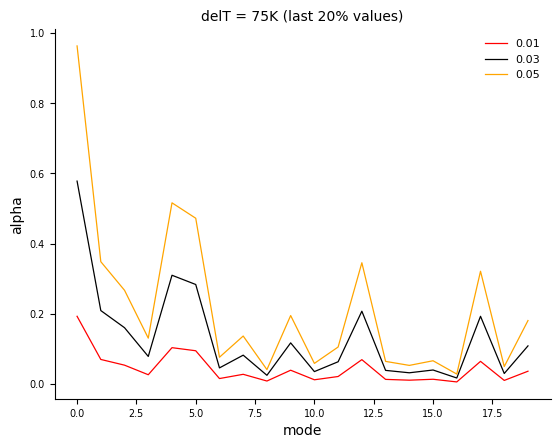

In [30]:
lst = [0.01, 0.03, 0.05]
alpha_75_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
    alpha_75_20.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 20% values)", fontsize = 10)
plt.show()

#### delT = 100; Finding the alpha

In [31]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_100[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_100, m)}

0.14403175494096307
[0.16205837 0.0472317  0.07117566 0.03218502 0.00767638 0.03871474
 0.01550096 0.00245288 0.03485619 0.01068617 0.00263107 0.02200273
 0.01521412 0.0077823  0.00362657 0.03080296 0.00140129 0.02334203
 0.00881748 0.00611408]
1.2962856523085557
[0.48616667 0.14169923 0.21355801 0.09658273 0.02300633 0.1161592
 0.04648517 0.00731715 0.1046169  0.03205988 0.00786969 0.06603186
 0.04568882 0.02329093 0.01086042 0.09234574 0.0042076  0.07000859
 0.02644634 0.01835933]
3.600793346280892
[0.81026401 0.23614721 0.35593605 0.16096832 0.03829386 0.19360255
 0.07748317 0.01217821 0.17436788 0.05342493 0.01312672 0.11002059
 0.07611524 0.03882258 0.01810581 0.15393658 0.00701723 0.11669515
 0.04408504 0.03060518]


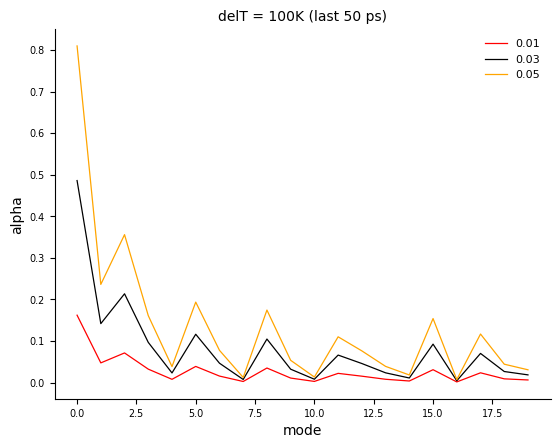

In [32]:
lst = [0.01, 0.03, 0.05]
alpha_100_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_100 = result.x
    alpha_100_5.append(alpha_m_100)
    print(argmin(alpha_m_100, wm))
    print(alpha_m_100)
    ax.plot(alpha_m_100, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 100K (last 50 ps)", fontsize = 10)
plt.show()

In [33]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_100[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_100, m)}

0.14134045618133295
[0.1554596  0.06179831 0.06691232 0.02935996 0.01128412 0.03369551
 0.01840921 0.00479007 0.03517552 0.0128285  0.00362742 0.0222913
 0.01741054 0.00780968 0.00268835 0.02838571 0.00243188 0.02413459
 0.00828991 0.0078536 ]
1.2720641377790403
[0.46638139 0.18540253 0.20075392 0.08809056 0.03379998 0.10108651
 0.05521921 0.01435399 0.10554884 0.03849757 0.01090811 0.06687769
 0.05221218 0.02340201 0.00806139 0.08514628 0.00729219 0.07239653
 0.02486469 0.02357838]
3.5335112807092983
[0.77727657 0.30895891 0.33463238 0.14682039 0.05652133 0.16845974
 0.09206168 0.0238982  0.17589229 0.0641232  0.01807035 0.1113869
 0.08703547 0.03899976 0.01344015 0.14194969 0.01216112 0.12068322
 0.04145118 0.03930544]


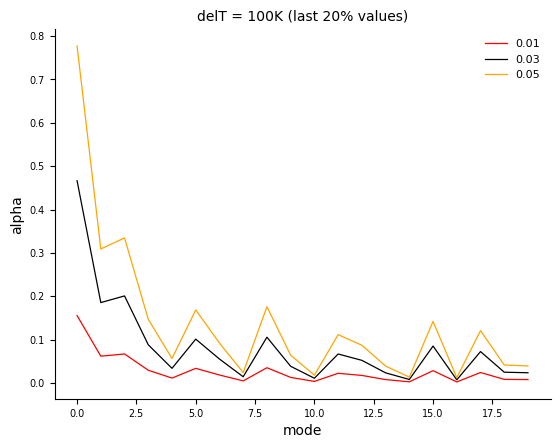

In [34]:
lst = [0.01, 0.03, 0.05]
alpha_100_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_100 = result.x
    alpha_100_20.append(alpha_m_100)
    print(argmin(alpha_m_100, wm))
    print(alpha_m_100)
    ax.plot(alpha_m_100, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 100K (last 20% values)", fontsize = 10)
plt.show()

Text(0.02, 0.5, 'alpha')

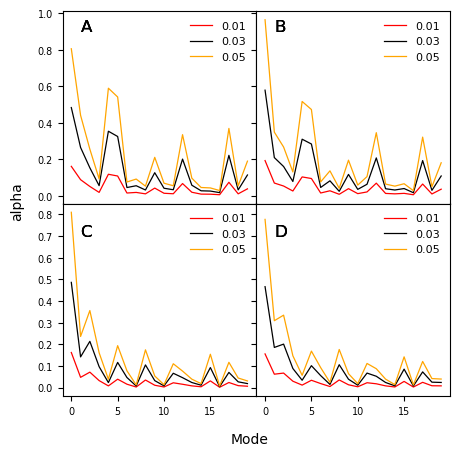

In [35]:
#fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 0].text(1, 0.9, "A", fontsize = 12)
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].text(1, 0.9, "B", fontsize = 12)
    axes[1, 0].plot(mode_lst, alpha_100_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].text(1, 0.7, "C", fontsize = 12)
    axes[1, 1].plot(mode_lst, alpha_100_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].text(1, 0.7, "D", fontsize = 12)
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

Text(0.02, 0.5, 'alpha')

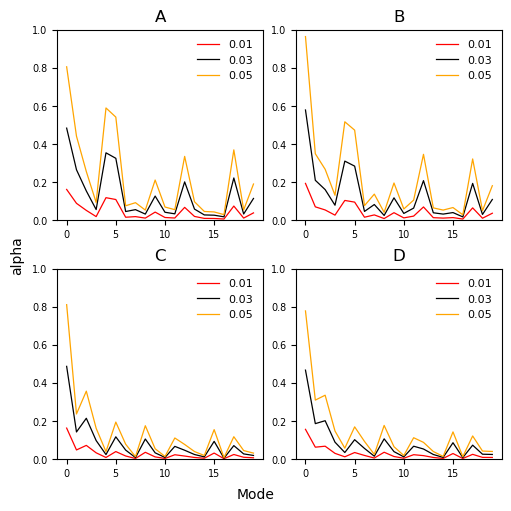

In [36]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 0].set_ylim(0, 1.0)
    axes[0, 0].set_title('A', fontsize = 12)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 1].set_ylim(0, 1.0)
    axes[0, 1].set_title('B', fontsize = 12)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].plot(mode_lst, alpha_100_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 0].set_ylim(0, 1.0)
    axes[1, 0].set_title('C', fontsize = 12)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].plot(mode_lst, alpha_100_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 1].set_ylim(0, 1.0)
    axes[1, 1].set_title('D', fontsize = 12)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

In [37]:
d_75_5 = np.zeros((3, Um[0].shape[0]))
d_75_20 = np.zeros((3, Um[0].shape[0]))
d_100_5 = np.zeros((3, Um[0].shape[0]))
d_100_20 = np.zeros((3, Um[0].shape[0]))
for i in range(m):
    for j in range(3):
        d_75_5[j] += alpha_75_5[j][i]*Um[i]
        d_75_20[j] += alpha_75_20[j][i]*Um[i]
        d_100_5[j] += alpha_100_5[j][i]*Um[i]
        d_100_20[j] += alpha_100_20[j][i]*Um[i]
        d_75_5[j] = d_75_5[j]/np.linalg.norm(d_75_5[j])
        d_75_20[j] = d_75_20[j]/np.linalg.norm(d_75_20[j])
        d_100_5[j] = d_100_5[j]/np.linalg.norm(d_100_5[j])
        d_100_20[j] = d_100_20[j]/np.linalg.norm(d_100_20[j])

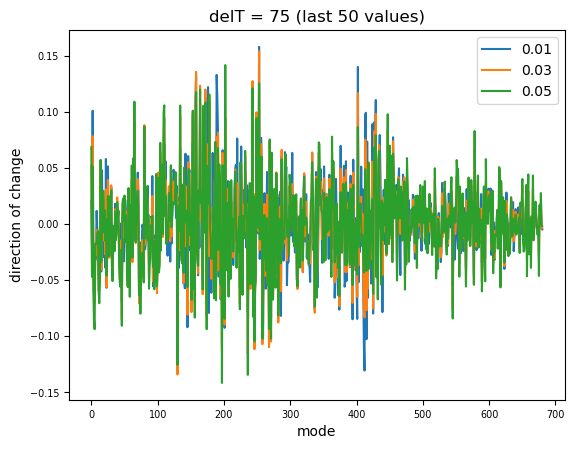

In [38]:
xi_lst = [0.01, 0.03, 0.05]
for i in range(3):
    plt.plot(d_75_5[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

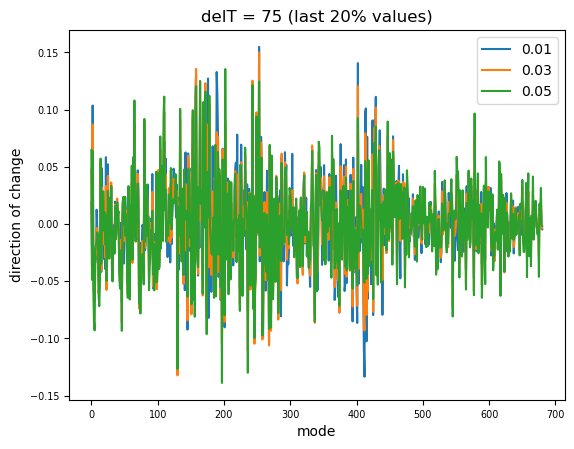

In [39]:
for i in range(3):
    plt.plot(d_75_20[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

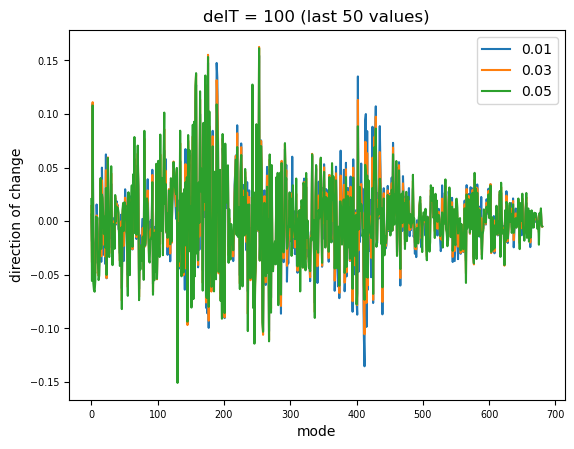

In [40]:
for i in range(3):
    plt.plot(d_100_5[i], label = str(xi_lst[i]))
    plt.title("delT = 100 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

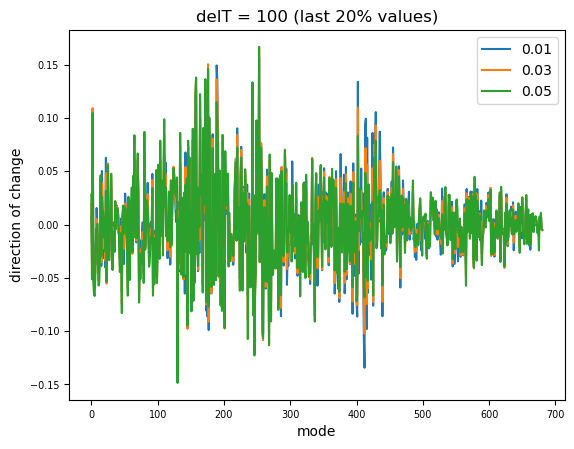

In [41]:
for i in range(3):
    plt.plot(d_100_20[i], label = str(xi_lst[i]))
    plt.title("delT = 100 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

In [42]:
all_d = []
for i in range(3):
    all_d.append(d_75_5[i])
for i in range(3):
    all_d.append(d_75_20[i])
for i in range(3):
    all_d.append(d_100_5[i])
for i in range(3):
    all_d.append(d_100_20[i])

In [43]:
dot_product = np.zeros((len(all_d), len(all_d)))
for i in range(len(all_d)):
    for j in range(len(all_d)):
        dot_product[i, j] = np.dot(all_d[i], all_d[j])

In [44]:
dot_product

array([[1.        , 0.91370329, 0.72723059, 0.99943765, 0.93307926,
        0.76967601, 0.98615361, 0.96901882, 0.90639891, 0.98710312,
        0.96980392, 0.90501637],
       [0.91370329, 1.        , 0.94159455, 0.90440145, 0.99610548,
        0.95764549, 0.84299897, 0.89317783, 0.89830854, 0.84598929,
        0.90016376, 0.90695547],
       [0.72723059, 0.94159455, 1.        , 0.71278358, 0.92067689,
        0.99303627, 0.6199017 , 0.71558414, 0.77348479, 0.62372687,
        0.72548316, 0.78739001],
       [0.99943765, 0.90440145, 0.71278358, 1.        , 0.92663513,
        0.75869557, 0.98954328, 0.97023796, 0.90560471, 0.99021908,
        0.97024616, 0.90306897],
       [0.93307926, 0.99610548, 0.92067689, 0.92663513, 1.        ,
        0.9468011 , 0.87196962, 0.91700577, 0.91630501, 0.87435797,
        0.92224325, 0.92230563],
       [0.76967601, 0.95764549, 0.99303627, 0.75869557, 0.9468011 ,
        1.        , 0.6727777 , 0.76432722, 0.81606144, 0.67605816,
        0.7725985 ,

## 3. Friction matrix 

In [45]:
# saving after every 0.001 seconds, simulation length = 200ps
vel = np.loadtxt("/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/vel_001.xvg", comments=["@", "#"], unpack=True)
time = vel[0]
vel = vel[1:]

In [46]:
len(vel[0])

200001

In [47]:
vel_x = np.zeros((len(time), n_res))
vel_y = np.zeros((len(time), n_res))
vel_z = np.zeros((len(time), n_res))
for j in range(len(time)):
    vel_xx = []
    vel_yy = []
    vel_zz = []
    for i in range(0, n_res):
        vel_xx.append(vel[i*3+0][j])
        vel_yy.append(vel[i*3+1][j])
        vel_zz.append(vel[i*3+2][j])
    vel_x[j] = vel_xx
    vel_y[j] = vel_yy
    vel_z[j] = vel_zz

In [48]:
# Compute omega and initialize velocity array
n_l = n_res
m_l = n_l * 3
n = len(time)
velocity = np.zeros((m_l, n))
velocity[0:m_l:3, :] = vel_x.T
velocity[1:m_l:3, :] = vel_y.T
velocity[2:m_l:3, :] = vel_z.T

# Compute correlation function
cvv = np.zeros((11, m_l), dtype=np.float32)
for frame_diff in range(0, 11):
    velacc = np.zeros((1, m_l), dtype=np.float32)
    ind = 0
    for frame in range(199991):
        ind += 1
        velacc += np.transpose(velocity[:, frame] * velocity[:, frame + frame_diff])
    velacc /= ind
    cvv[frame_diff, :] = velacc[0]

Text(0, 0.5, 'Cvv matrix values')

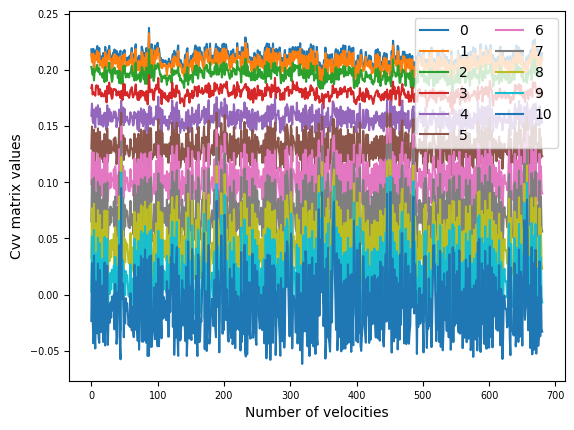

In [49]:
for i in range(11):
    plt.plot(cvv[i], label = str(i))
#plt.title("Cvv matrix")
plt.legend(loc ="upper right", ncol = 2, prop={'size':10})
plt.xlabel("Number of velocities")
plt.ylabel("Cvv matrix values")

Text(0, 0.5, 'Cvv values')

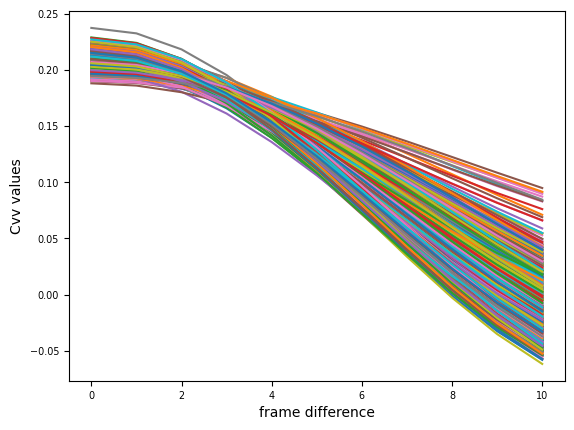

In [50]:
for i in range(681):
    plt.plot(cvv[:, i])
plt.xlabel("frame difference")
plt.ylabel("Cvv values")

In [51]:
# Compute friction and friction_NM: 0th and 5th frame each 681 entries....difference in cvv divide by time -> friction matrix (daig) element wise division
friction = cvv[4, :] - cvv[0, :]
friction = -friction/(5*0.001)
residue_mass = CA.residues.masses/1000
residue_mass = np.repeat(residue_mass, 3)
for i in range(681):
    friction[i] = friction[i]/residue_mass[i]
friction = friction/(8.3144*310*0.001) # ps-1
friction = np.diag(friction)
print(friction)
friction_NM = []
for i in range(20):
    friction_NM.append(Um[i].T @ friction @ Um[i])
print(friction_NM)

[[41.57997   0.        0.       ...  0.        0.        0.      ]
 [ 0.       28.07749   0.       ...  0.        0.        0.      ]
 [ 0.        0.       39.27754  ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 41.607197  0.        0.      ]
 [ 0.        0.        0.       ...  0.       55.23566   0.      ]
 [ 0.        0.        0.       ...  0.        0.       58.296146]]
[43.244258091473135, 41.392527913176565, 43.62846970611537, 46.465088269505934, 44.08532071802293, 47.20642951832856, 43.066253547195004, 43.88811151339842, 43.155667713868624, 43.512176574939176, 43.58934165666828, 42.18704945910603, 41.9188463299844, 42.026869393906054, 43.61935149976783, 45.86431489179651, 46.441489693685, 44.92027093197754, 44.66076563756827, 46.506794189918224]


## 4. Estimating beta_m 

[25.82691878  9.29349736  7.54381125  4.09607234 15.9718772  16.06202197
  2.48424451  4.53201249  1.36986074  6.78019214  2.02990827  3.41150043
 10.33244335  1.88085185  1.55646595  2.12570801  0.88266758  8.57855667
  1.43919508  5.41346818]


Text(0.5, 1.0, 'delT = 75 K')

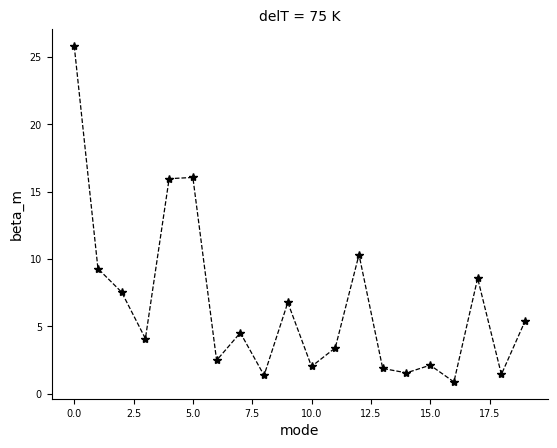

In [52]:
#for delT = 75
a = np.zeros(m)
b = np.zeros(m)
beta_m_75 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_75[i] = alpha_75_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_75)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_75, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

[20.83004822  8.24028965  9.45376123  4.61068902  1.74270841  5.72870946
  3.00956285  0.79438703  5.90985443  2.2324257   0.63159616  3.61612344
  2.60274942  1.14388018  0.3966854   4.57340401  0.38377724  3.22263868
  1.20658416  1.17777405]


Text(0.5, 1.0, 'delT = 100 K')

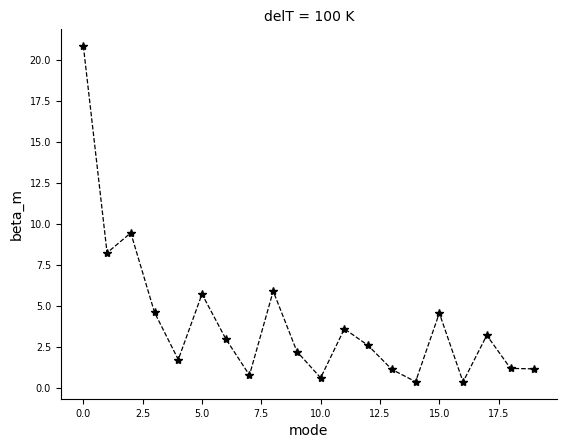

In [53]:
#for delT = 100
a = np.zeros(m)
b = np.zeros(m)
beta_m_100 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_100[i] = alpha_100_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_100)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_100, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 100 K", fontsize = 10)

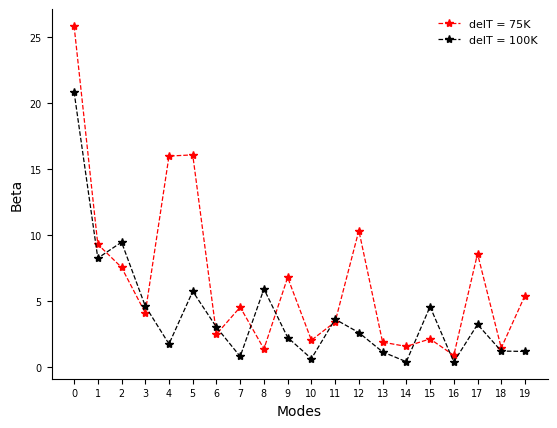

In [54]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(mode_lst, beta_m_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(mode_lst, beta_m_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
plt.xlabel("Modes", fontsize = 10)
plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("Beta", fontsize = 10)
#plt.title("Average RMSD for separate modes", fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':8})

## 5. Degree of excitation 

In [55]:
# for delT = 75
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_75[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 75 K')

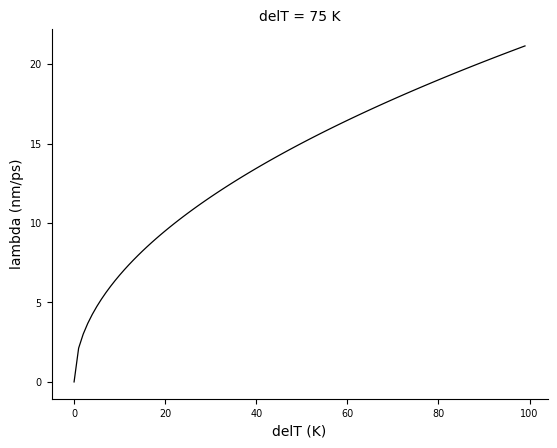

In [56]:
delT = range(0, 100)
lam_75 = []
for k in delT:
    lam_75.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_75, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

In [ ]:
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_100[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 100 K')

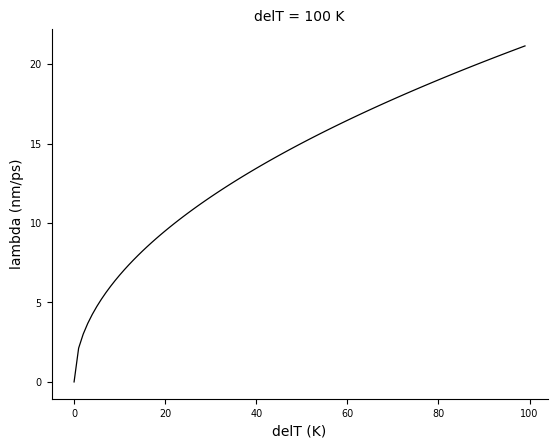

In [57]:
delT = range(0, 100)
lam_100 = []
for k in delT:
    lam_100.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_100, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 100 K", fontsize = 10)

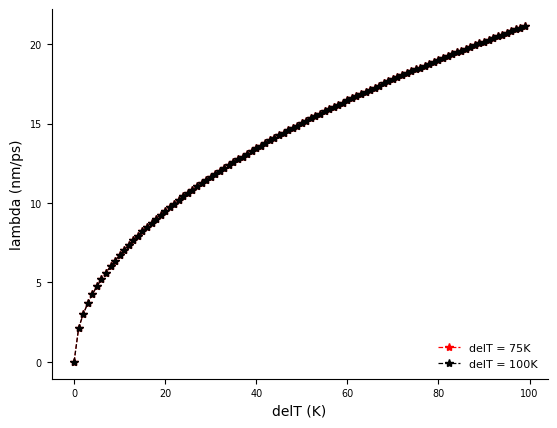

In [58]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(delT, lam_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(delT, lam_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
plt.xlabel("delT (K)", fontsize = 10)
#plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="lower right", ncol = 1, prop={'size':8})

### Excitation along normal modes

In [48]:
cutoff = opt_Rc
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
H_m = get_mass_weighted_H(M_f, H)
[v, U_m] = np.linalg.eig(H_m)
arr_v = v
U_m = U_m[:, np.argsort(v)]
v = v[np.argsort(v)]  #eigenvalue
U = M_f @ U_m  #eigenvector

/var/tmp/pbs.3532452.pbshpc/ipykernel_16364/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


In [73]:
box = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/box.pdb"
pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_75[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [75]:
def save_gro(Um, v_extra, gro_in, delT):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = '/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_{}_delT/md.gro'.format(delT)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [76]:
gro_in = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_50_delT/md_base.gro"
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130]
for i in delT:
    v_extra = excite(Um, box, i)
    save_gro(Um, v_extra, gro_in, i)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_10_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_20_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_30_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_40_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_50_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_60_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_75_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_80_delT/md.gro
W

## New structures (excitation alogn direction of min energy)

In [59]:
box = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/box.pdb"
pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_75[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

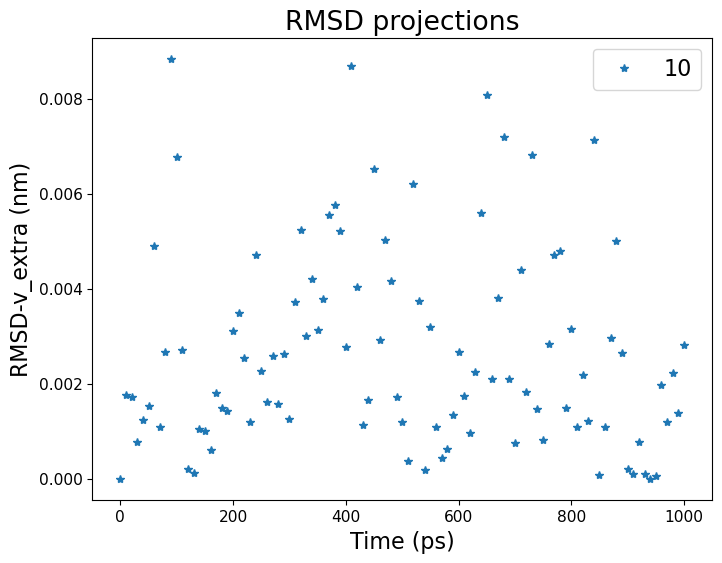

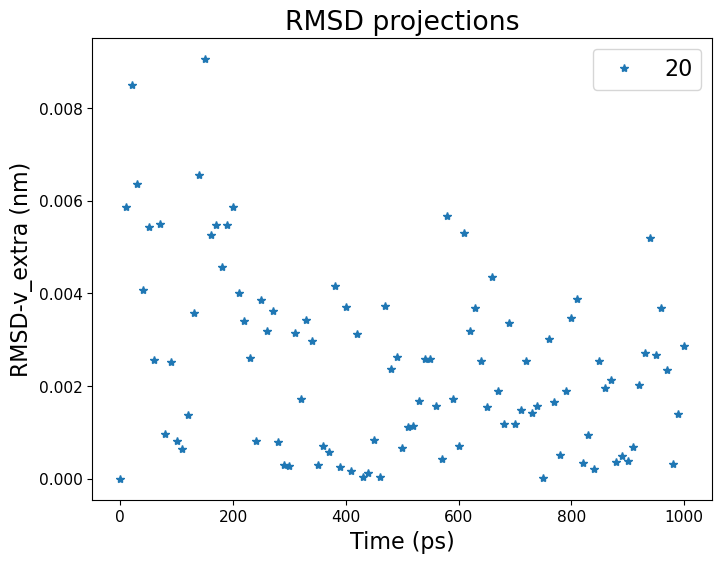

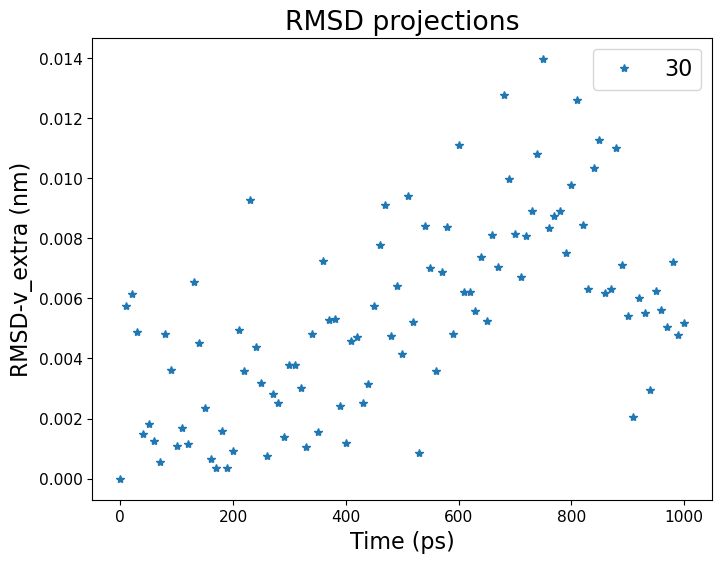

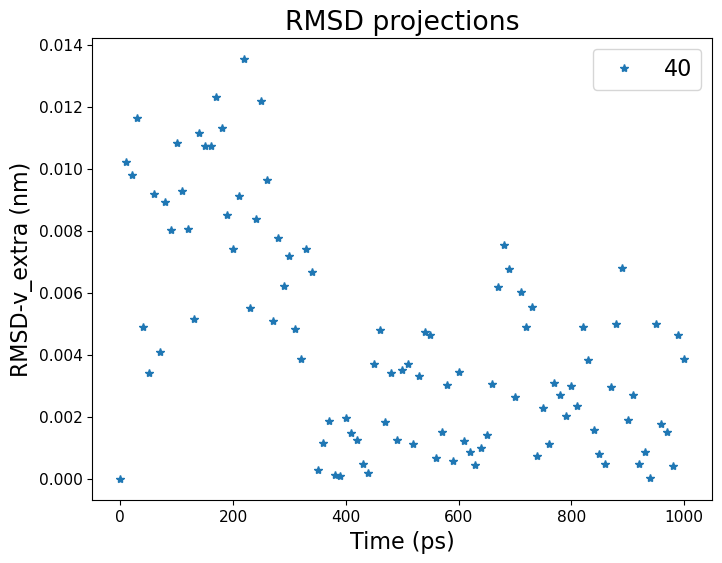

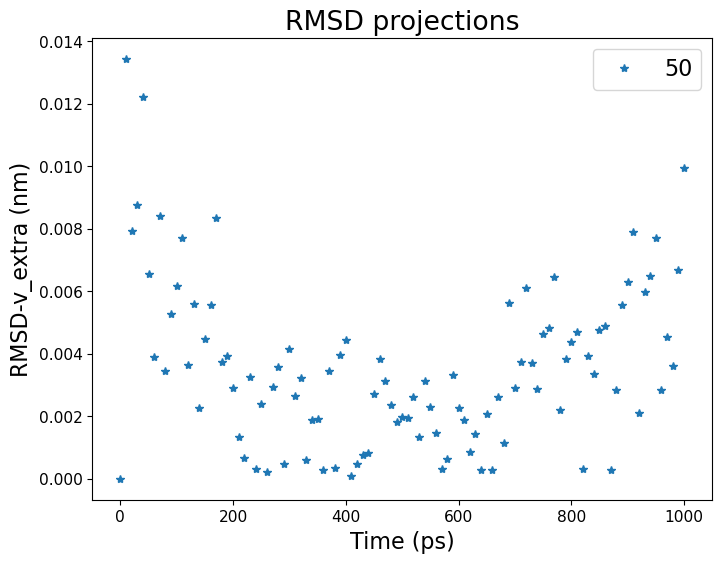

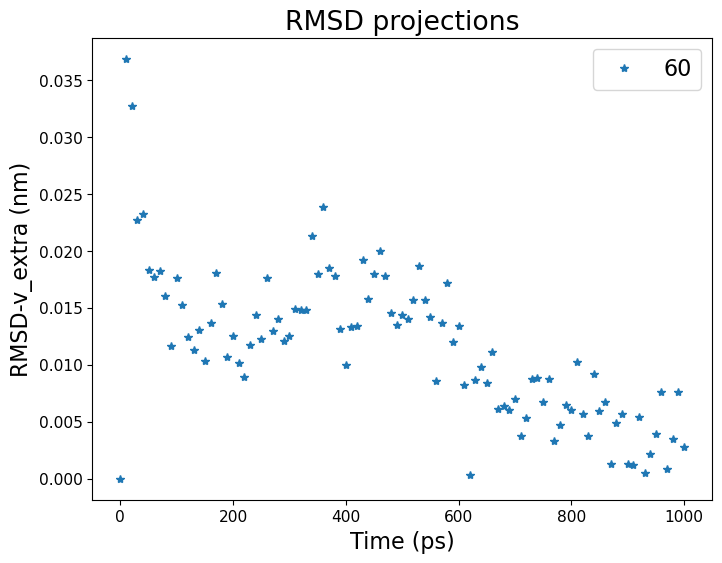

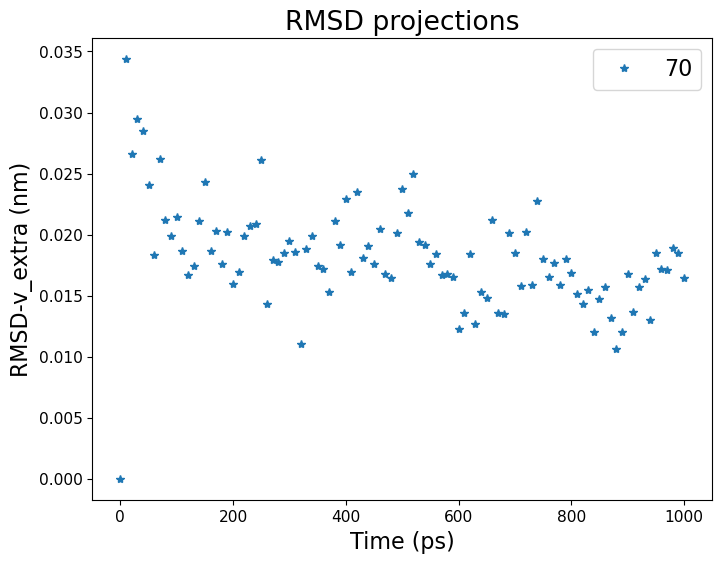

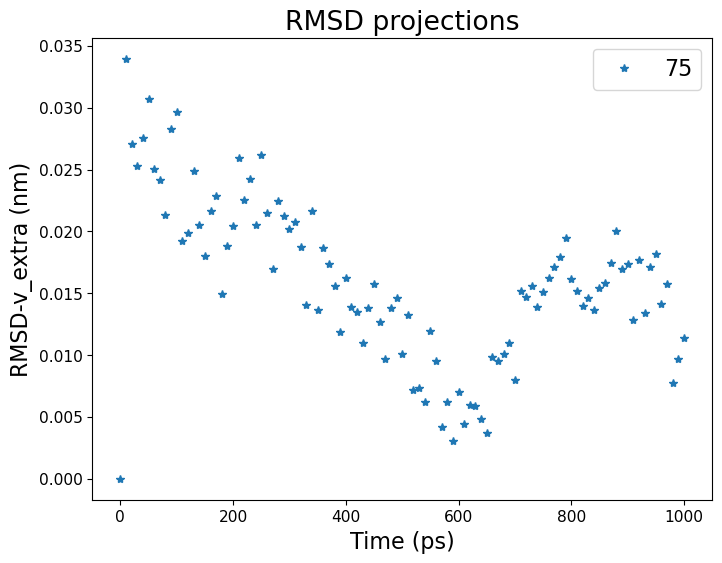

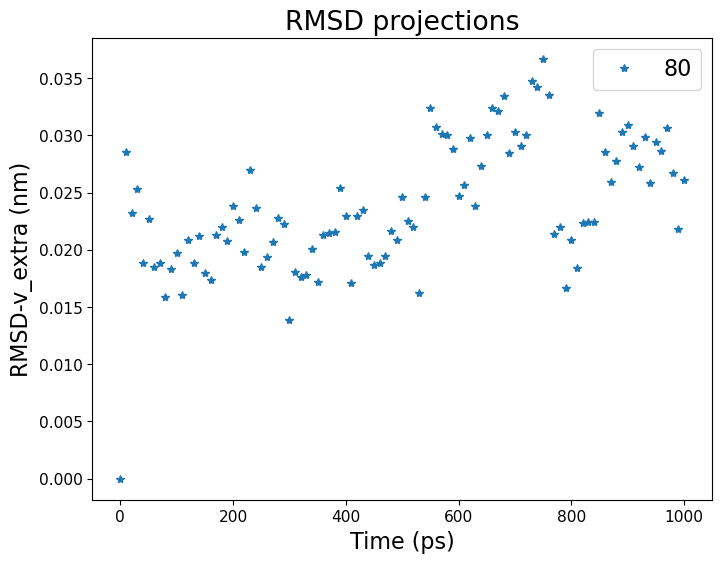

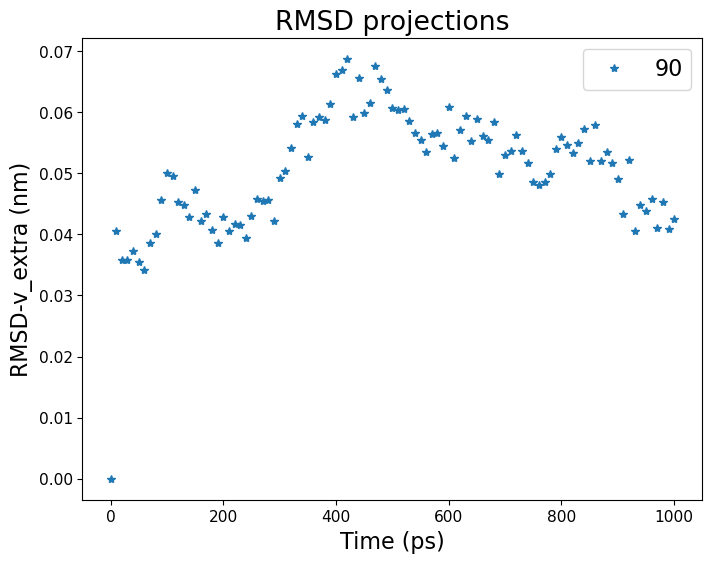

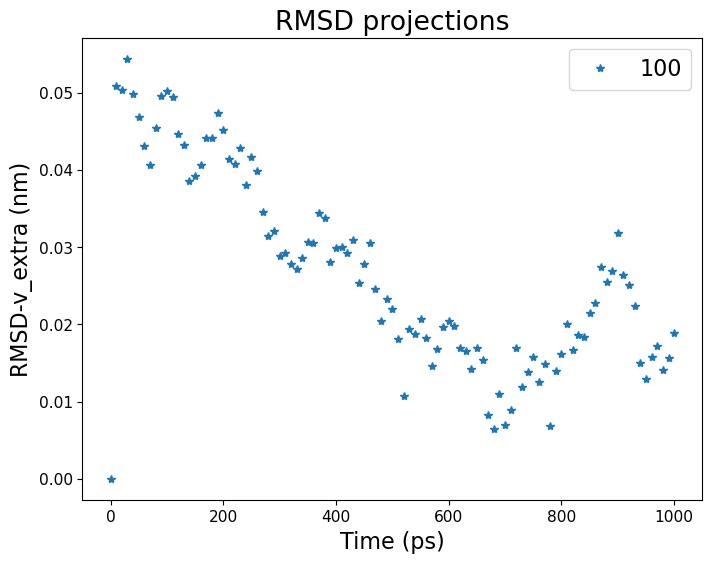

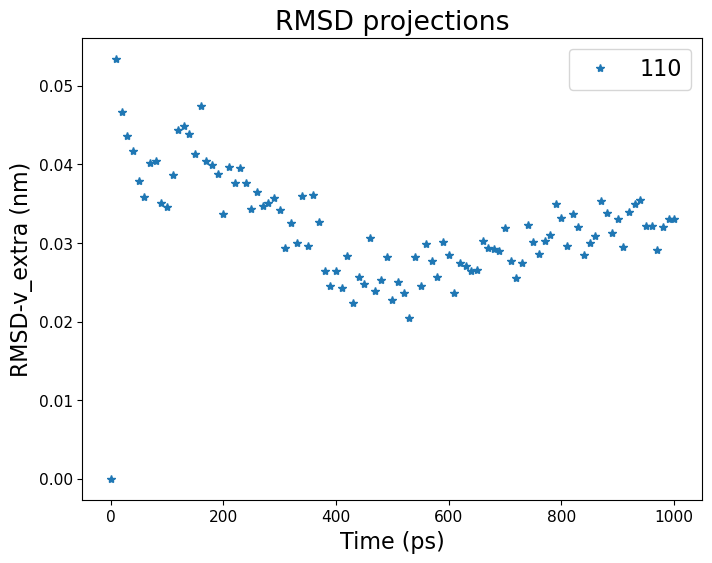

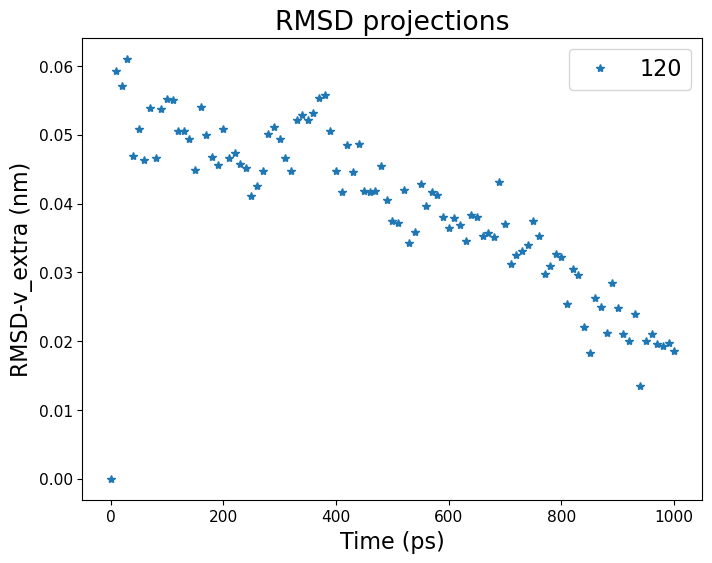

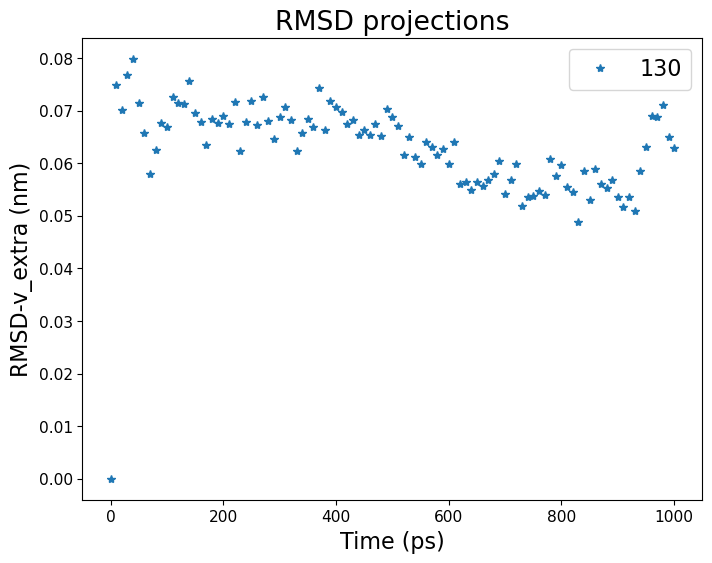

In [60]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130]
prmsd = []
time = [i*10 for i in range(101)]
for k in range(len(delT)):
    pdb_mdenm = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_{}_delT/pdb_mdenm.pdb".format(delT[k])
    xtc_mdenm = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_{}_delT/xtc_mdenm.xtc".format(delT[k])
    pdb_ref = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, delT[k])]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    prmsd.append(z_v)
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = '16'
    plt.plot(time, z_v, '*')
    plt.title('RMSD projections')
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD-v_extra (nm)')
    plt.legend([str(delT[k])])

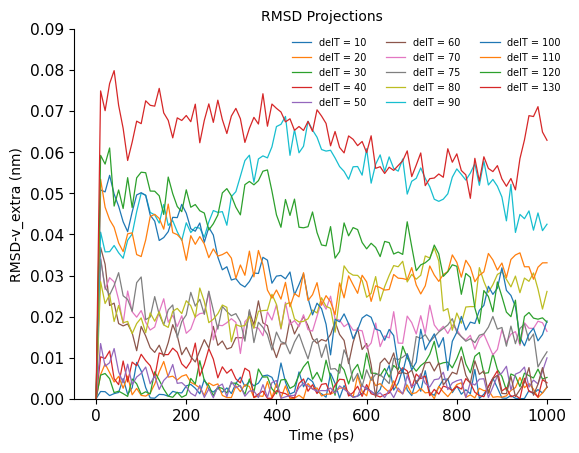

In [61]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130]
time = [i*10 for i in range(101)]
fig, ax = plt.subplots()
for k in range(len(delT)): 
    ax.plot(time, prmsd[k], label = 'delT = {}'.format(str(delT[k])), linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':7})
    ax.set_xlabel('Time (ps)', fontsize = 10)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 10)
    ax.set_ylim(0, 0.09)
    ax.set_title('RMSD Projections', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()

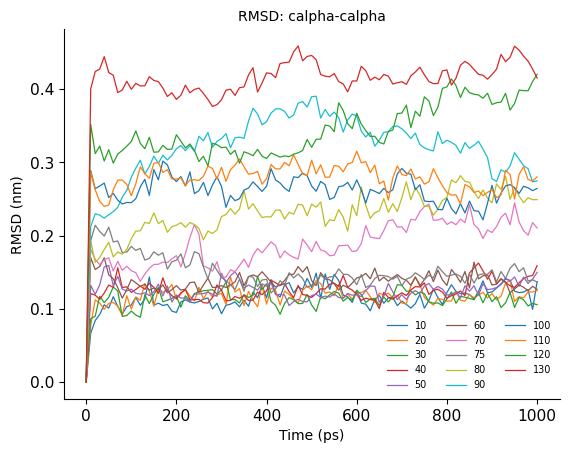

In [62]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130]
rmsd = []
fig, ax = plt.subplots()
for k in range(len(delT)):
    filename = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_{}_delT/rmsd_calpha_calpha.xvg".format(delT[k])
    rmsd_value = np.genfromtxt(filename, skip_header = 18)
    rmsd.append(rmsd_value[:, 1])
    ax.plot(rmsd_value[:, 0], rmsd_value[:, 1], label = str(delT[k]), linewidth = 0.9)
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.set_xlabel("Time (ps)", fontsize = 10)
ax.set_ylabel("RMSD (nm)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("RMSD: calpha-calpha", fontsize = 10)
plt.legend(frameon = False, loc='lower right', ncol = 3, prop={'size':7})

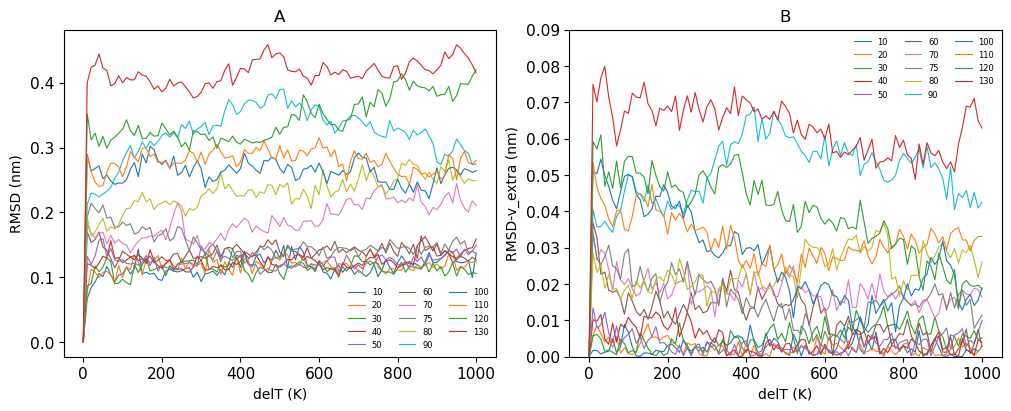

In [63]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for k in range(len(delT)):
    axes[0].plot(time, rmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[0].set_xlabel("delT (K)", fontsize = 10)
    axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
    axes[0].set_title("A", fontsize = 12)
    axes[0].legend(frameon = False, loc ="lower right", ncol = 3, prop={'size':6})
    axes[1].plot(time, prmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[1].set_xlabel("delT (K)", fontsize = 10)
    axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
    axes[1].set_title("B", fontsize = 12)
    axes[1].set_ylim(0, 0.09)
    axes[1].legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':6})

Text(0.5, 1.0, 'B')

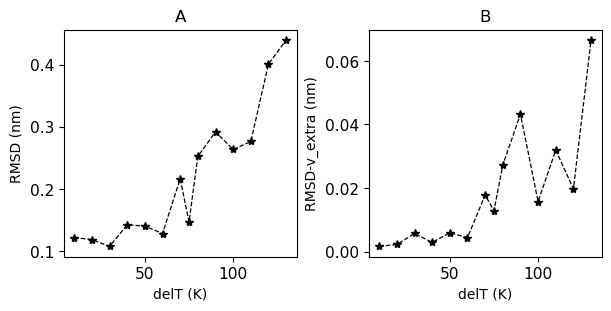

In [64]:
avg_rmsd = []
avg_prmsd = []
for k in range(len(delT)):
    avg_rmsd.append(np.average(rmsd[k][95:]))
    avg_prmsd.append(np.average(prmsd[k][95:]))

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[0].set_xlabel("delT (K)", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[1].set_xlabel("delT (K)", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)
    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)